# ML for cybersecurity - Exploration

## Project objectives

The goal of the project is to design, deploy and evaluate a data chain for the analysis of
cybersecurity data. The data treatment will be performed as batch.

This notebook will be used to explore the data and try to find some interesting insights.

### Data description

This paper presents a dataset to support researchers in the validation process of solutions such
as Intrusion Detection Systems (IDS) based on artificial intelligence and machine learning techniques for
the detection and categorization of threats in Cyber Physical Systems (CPS). To this end, data were acquired
from a hardware-in-the-loop Water Distribution Testbed (WDT) which emulates water flowing between eight
tanks via solenoid-valves, pumps, pressure and flow sensors. The testbed is composed of a real subsystem
that is virtually connected to a simulated one. The proposed dataset encompasses both physical and network
data in order to highlight the consequences of attacks in the physical process as well as in network traffic
behaviour. Simulations data are organized in four different acquisitions for a total duration of 2 hours by
considering normal scenario and multiple anomalies due to cyber and physical attacks.

### Importing libraries

In [1]:
from preprocess_data import get_HITL, clean_HITL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random_state = 42

### Loading data

As both types of datasets have different structures, we will load them separately.

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict)  # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


## Network dataset exploration

In [3]:
df_network.head()

,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,label_n,label,attack
0,1.617993e+09,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal,1
1,1.617993e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,[0],0,normal,1
2,1.617993e+09,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,NaN,0,normal,1
3,1.617993e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal,1
4,1.617993e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,[0],0,normal,1


In [4]:
df_network.columns

Index(['time', 'mac_s', 'mac_d', 'ip_s', 'ip_d', 'sport', 'dport', 'proto',
       'flags', 'size', 'modbus_fn', 'n_pkt_src', 'n_pkt_dst',
       'modbus_response', 'label_n', 'label', 'attack'],
      dtype='object')

The `attack` column come from the cleanup of the dataset to differentiate between normal and attack datasets.


Dtypes of the columns:

In [5]:
df_network.dtypes

time               float64
mac_s               object
mac_d               object
ip_s                object
ip_d                object
sport              float64
dport              float64
proto               object
flags              float64
size                 int64
modbus_fn           object
n_pkt_src          float64
n_pkt_dst          float64
modbus_response     object
label_n              int64
label               object
attack               int64
dtype: object

Let's look at the proportion of nan values per column:

In [6]:
df_network.isna().sum() / df_network.shape[0] * 100

time                0.000000
mac_s               0.000000
mac_d               0.000000
ip_s                0.003703
ip_d                0.003703
sport              14.194146
dport              14.194146
proto               0.000000
flags              14.194146
size                0.000000
modbus_fn          16.644108
n_pkt_src           0.003703
n_pkt_dst           0.003703
modbus_response    58.290169
label_n             0.000000
label               0.000000
attack              0.000000
dtype: float64

`modbus_response` is made out of more than half of nan values, trying to remove this column later on might be a good idea to reduce the dimensionality of the dataset.

`sport`, `dport` and `flags` are all numerical columns so we can interpolate some values to fill the nan values later on. Theses columns seem to be interesting to play with/without to see how they impact the model.

A PCA could be interesting to reduce the dimensionality of the dataset as 5 columns contain lots of nan values.

### Labels

Let's take a quick detour to see what are the labels like.

In [7]:
network_dataset_labels = df_network[["label_n", "label", "attack"]]
df_network = df_network.drop(columns=["label_n", "label", "attack"])

In [8]:
network_dataset_labels.head(3)

,label_n,label,attack
0,0,normal,1
1,0,normal,1
2,0,normal,1


In [9]:
network_dataset_labels["label_n"].value_counts()

label_n
0    176087
1     66978
Name: count, dtype: int64

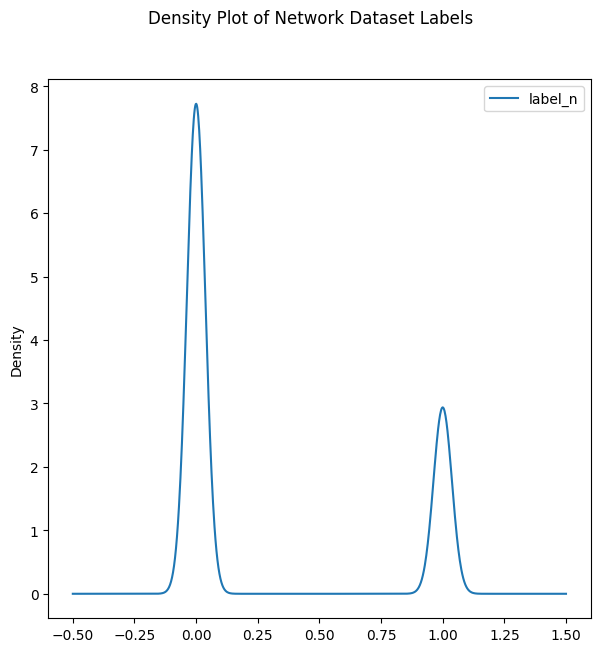

In [10]:
network_dataset_labels.loc[:, ["label_n"]].plot(
    kind="density",
    subplots=True,
    layout=(1, 1),
    sharex=False,
    figsize=(7, 7),
    title="Density Plot of Network Dataset Labels",
)
plt.show()

Our dataset is unbalanced, the ratio seems to be 1/3.

In [11]:
network_dataset_labels["label"].value_counts()

label
normal            176087
DoS                37665
MITM               16841
physical fault     12469
anomaly                3
Name: count, dtype: int64

We have 5 labels: normal, DoS, MITM, physical fault, anomaly.
More imporantly the data is also split is normal (label_n=0) or not normal (label_n=1).

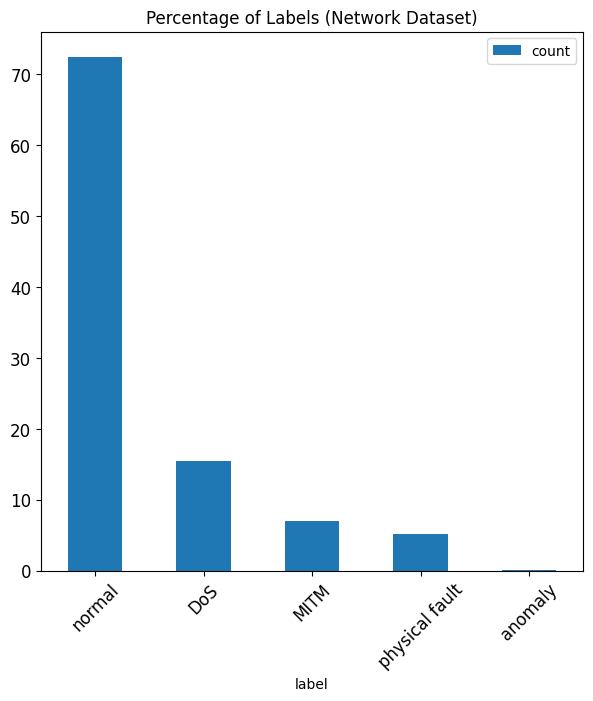

In [12]:
# Get dataset labels value counts
network_dataset_labels_value_counts = network_dataset_labels["label"].value_counts()

# Ratio of each label
network_dataset_labels_value_counts = (
    network_dataset_labels_value_counts
    / network_dataset_labels_value_counts.sum()
    * 100
)

# Bar plot of the dataset labels
network_dataset_labels_value_counts.plot(
    kind="bar",
    title="Percentage of Labels (Network Dataset)",
    figsize=(7, 7),
    rot=45,
    legend=True,
    fontsize=12,
)
plt.show()

### Features

__Numbers columns:__


In [13]:
network_number_cols = df_network.select_dtypes(
    include=["number"]
).columns.values.tolist()
network_number_cols.remove("time")  # Timestamp column
network_number_cols

['sport', 'dport', 'flags', 'size', 'n_pkt_src', 'n_pkt_dst']

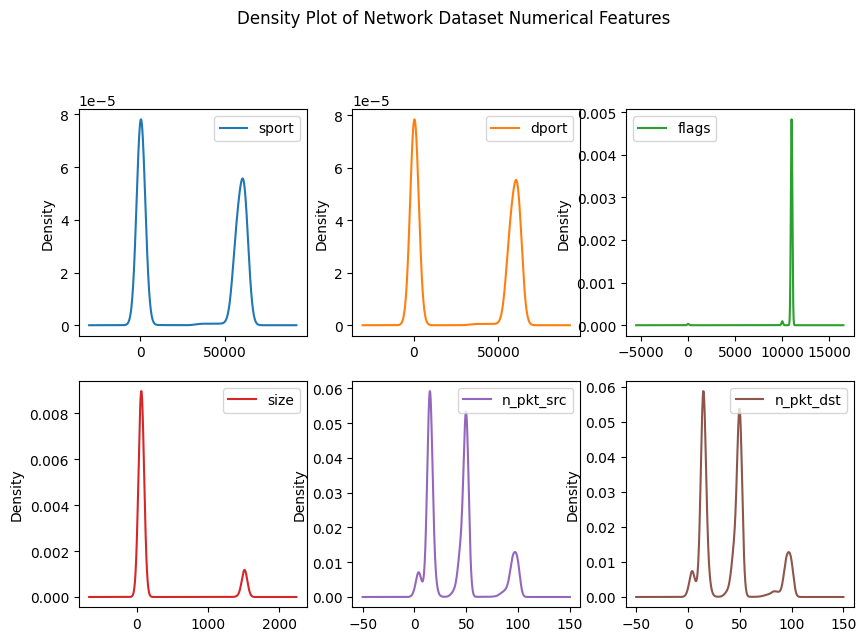

In [14]:
df_network[network_number_cols].plot(
    kind="density",
    subplots=True,
    layout=(3, 3),
    sharex=False,
    figsize=(10, 10),
    title="Density Plot of Network Dataset Numerical Features",
)
plt.show()

Let's quickly analyse the density of the numerical columns:
- `sport` and `dport`: two density spikes around 0 and 60000
- `flags`: a huge spike around 11000 and very few data around 10000 and 0
- `size`: two main spikes, the first one around 60 and the second one is around 1500, but 10x less dense
- `n_pkt_src` and `n_pkt_dst`: closer data with more dominant spikes, the two main ones are around 15 and 50

In [15]:
df_network.describe()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst
count,2.430650e+05,208564.000000,208564.000000,208564.000000,243065.000000,243056.000000,243056.000000
mean,1.618168e+09,29935.053614,29827.705903,10902.935909,236.671434,39.752514,39.561961
std,3.528267e+05,29495.006844,29513.480383,928.439179,467.620917,28.052526,27.835061
min,1.617968e+09,502.000000,502.000000,10.000000,60.000000,0.000000,0.000000
25%,1.617971e+09,502.000000,502.000000,11000.000000,65.000000,15.000000,15.000000
50%,1.617995e+09,33321.000000,502.000000,11000.000000,66.000000,44.000000,44.000000
75%,1.617998e+09,61317.000000,61317.000000,11000.000000,66.000000,50.000000,50.000000
max,1.618849e+09,61646.000000,61646.000000,11000.000000,1514.000000,100.000000,100.000000


Let's quickly analyse this:
- `n_pkt` columns range from 0 to a 100. Combined to what we saw on the density plot, we might be able to cluster them and reduce the dimensionality of the dataset.
- `flags` flags has a median of 10902 which is extremely close of the max value (which represents most of the density).
- `ports` look the same (density wise and range wise) but on a different scale. We might be able to cluster them as well.


__Object columns:__


In [16]:
network_categorical_cols = df_network.select_dtypes(
    include=["object"]
).columns.values.tolist()
network_categorical_cols

['mac_s', 'mac_d', 'ip_s', 'ip_d', 'proto', 'modbus_fn', 'modbus_response']

Let's look at the distribution of the object columns:

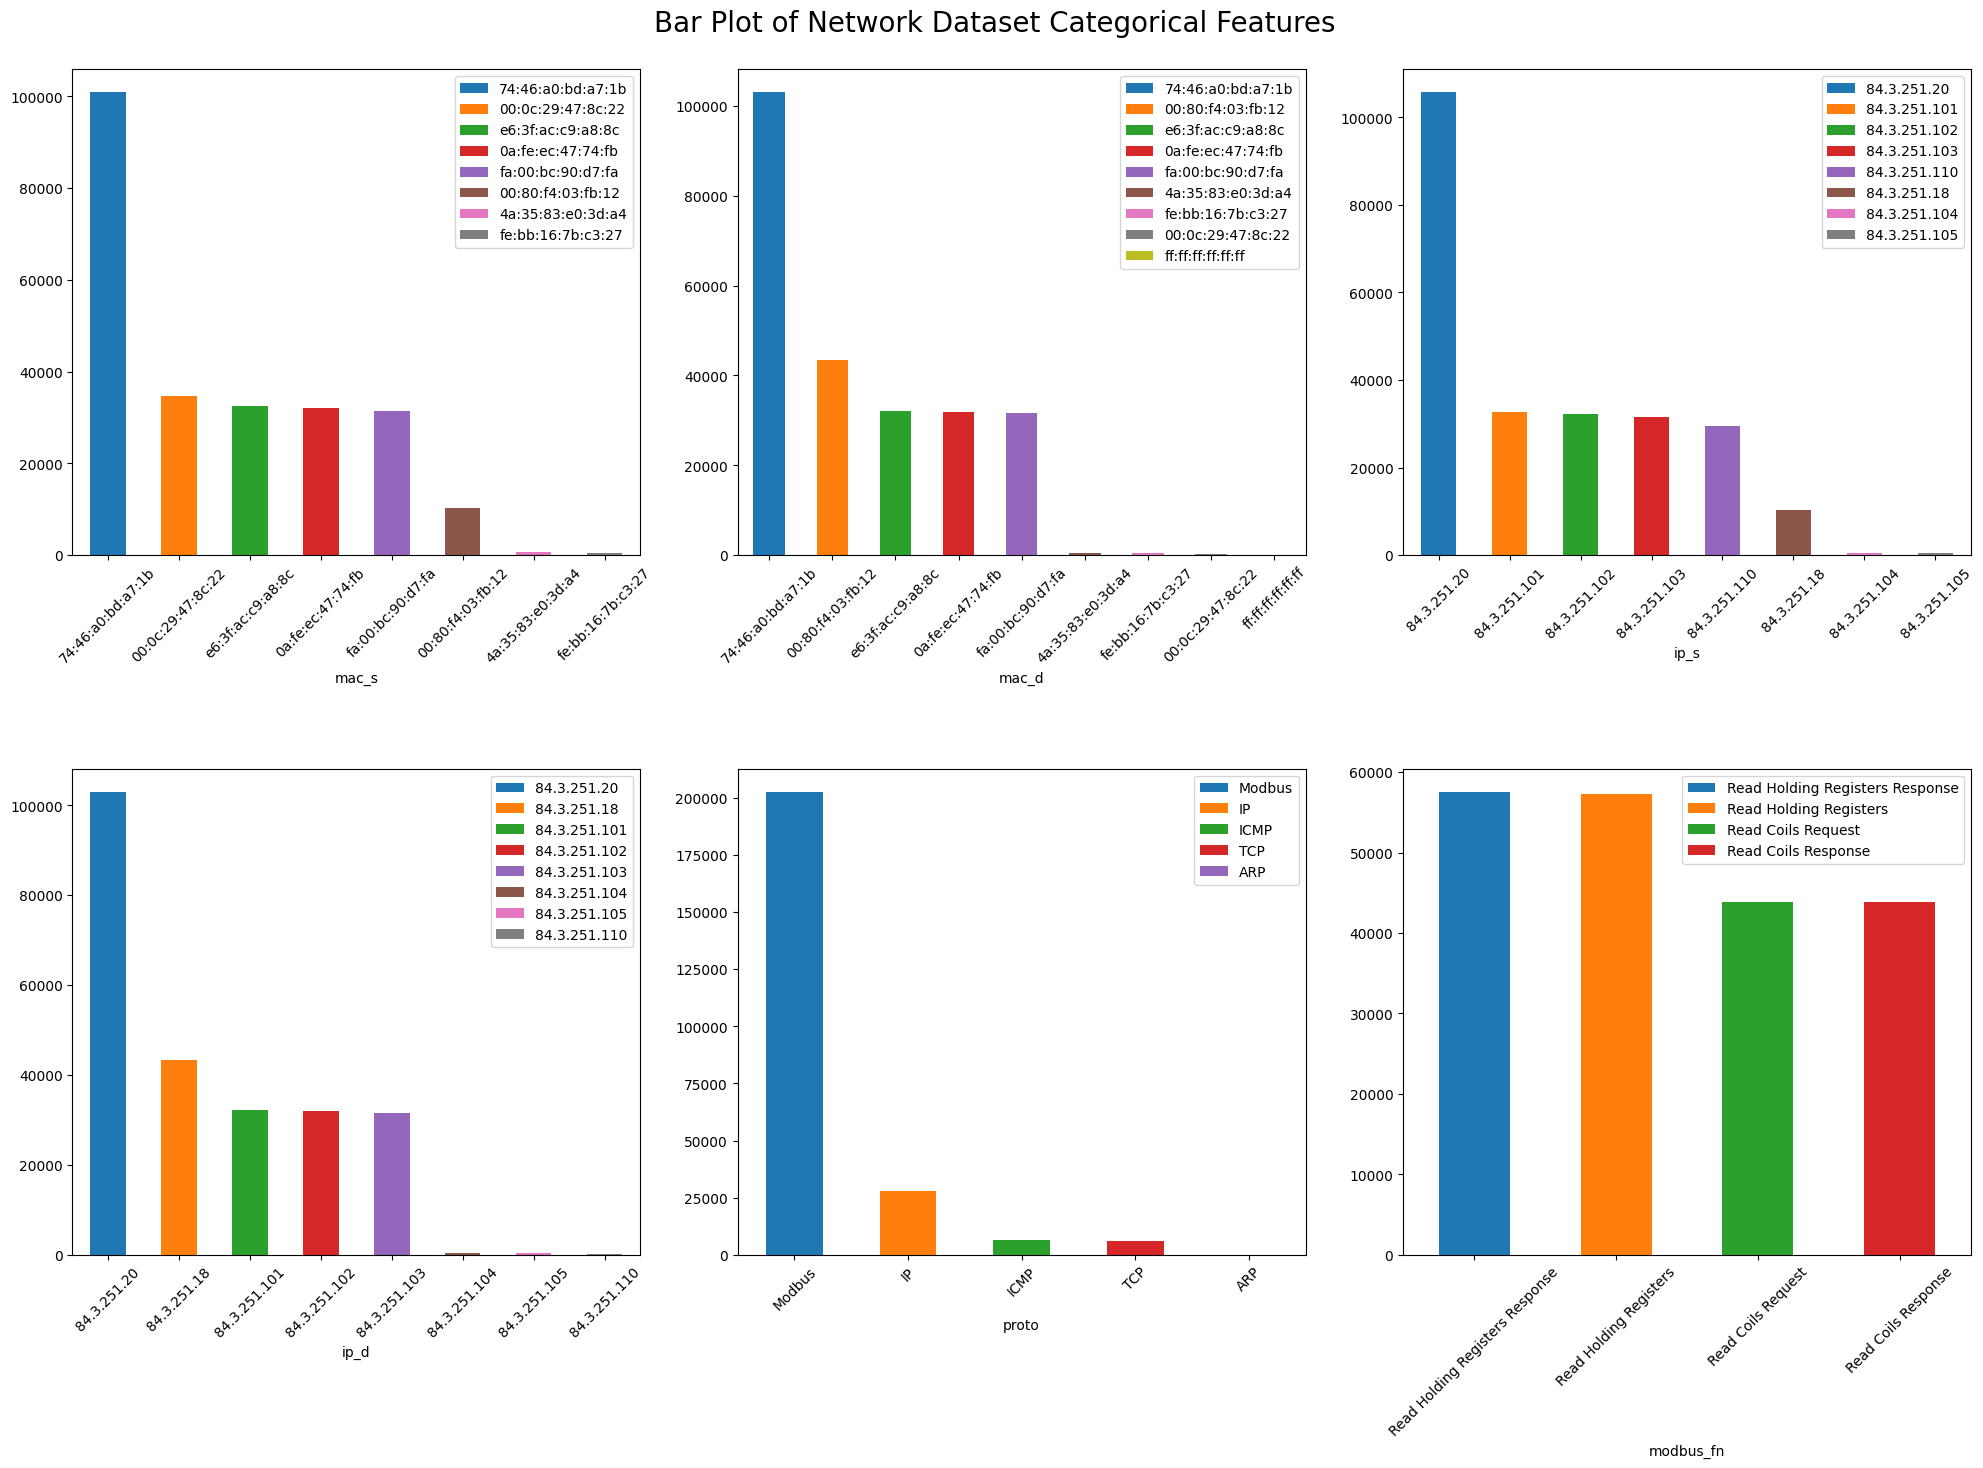

In [17]:
cols = [
    col for col in network_categorical_cols if col not in ["modbus_response", "Time"]
]  # Remove modbus_response (too many NaNs) and Time columns (not fit for this analysis)

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Bar Plot of Network Dataset Categorical Features", fontsize=20)
for i, col in enumerate(cols):
    ax = fig.add_subplot(3, 3, i + 1)
    value_count = df_network[col].value_counts()
    lines = value_count.plot(kind="bar", ax=ax)
    for j, patch in enumerate(ax.patches):
        patch.set_facecolor(f"C{j}")
        patch.set_label(value_count.index[j])
    ax.legend(handles=ax.patches)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

It is hard to deduce anything from the distributions, but we make the following observations:
- the distribution of `mac_s`, `mac_d`, `ip_s` and `ip_d` are very similar: one address is more frequent than the 7 others
- the distribution of `proto` is very unbalanced, with the "Modbus" protocol being 10x more frequent than the others. This column might be irrelevant for the classification
- the `modbus_response` data is very balanced between the 4 values.

We can see that most of our categorical features have <10 unique values.

In [18]:
def get_hist_pairs_per_column(dataset, col_name_1, col_name_2):
    # Sum each identical pair of ip addresses
    ip_pairs_count = {}
    for i, row in dataset.iterrows():
        ip_pair = (row[col_name_1], row[col_name_2])
        if ip_pair in ip_pairs_count:
            ip_pairs_count[ip_pair] += 1
        else:
            ip_pairs_count[ip_pair] = 1

    # Numerize each pair to print it on a graph
    ip_pairs_count_numerized = {}
    for i, (key, value) in enumerate(ip_pairs_count.items()):
        ip_pairs_count_numerized[i] = value

    # Plot the histogram
    plt.bar(ip_pairs_count_numerized.keys(), ip_pairs_count_numerized.values())
    plt.title(f"Number of occurences of each pair of {col_name_1} and {col_name_2}")
    plt.xlabel("Pair")
    plt.ylabel("Number of occurences")

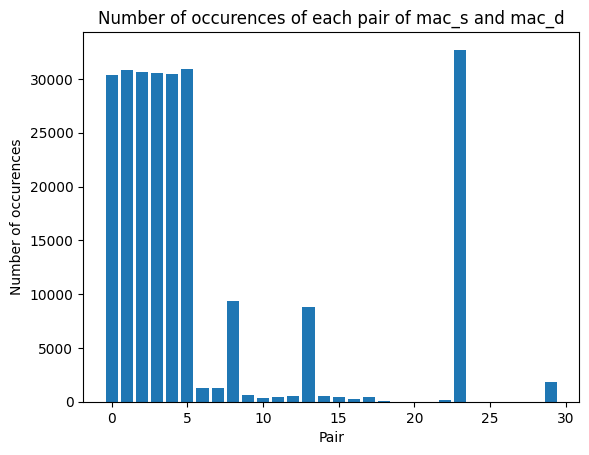

In [19]:
get_hist_pairs_per_column(df_network, "mac_s", "mac_d")

We have around 30 pairs of (mac_s, mac_d) that are unique. There are mostly 7-9 pairs that are mostly used.

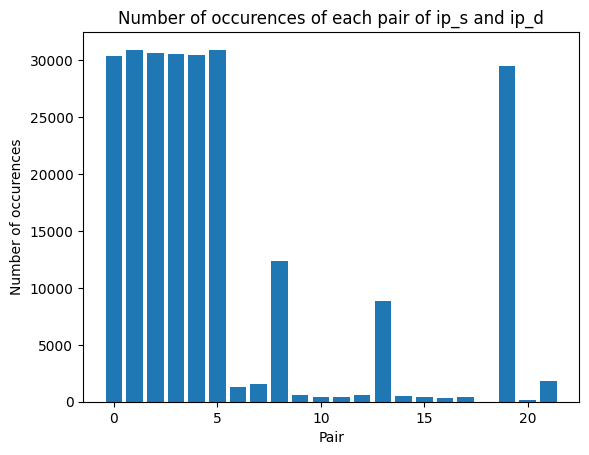

In [20]:
get_hist_pairs_per_column(df_network, "ip_s", "ip_d")

We have around 21 pairs of (ip_s, ip_d) that are unique. The repartition here is also a bit shallow as there are 7-9 pairs that are also mostly used. The repartition of the ip addresses is very similar to the mac addresses.

### Correlation between features

We'll first take a look at the correlation between the features that are the same types (numerical or categorical).

And then'll we'll broaden our analysis to all the features together to try and catch some interesting insights like maybe the correlation between the packets size and the port used.

In [21]:
from mlsecu.data_exploration_utils import (
    get_number_column_names,
    get_object_column_names,
)
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

# We'll remove the modbus_response column as it is has too many NaN values
# it would be hard to impute as we have so much categorical data
df_network = df_network.drop(columns=["modbus_response"])

# Get the number columns
number_cols = get_number_column_names(df_network)
number_cols.remove("time")  # Timestamp column
# Get the object columns
object_cols = get_object_column_names(df_network)

Let's compute and display the correlation matrix of the numbers columns first:

In [22]:
df_network[number_cols] = remove_nan_through_mean_imputation(df_network[number_cols])

corr_matrix = df_network[number_cols].corr(method="spearman").abs()
corr_matrix

,sport,dport,flags,size,n_pkt_src,n_pkt_dst
sport,1.000000,0.913909,0.018213,0.667260,0.653485,0.636953
dport,0.913909,1.000000,0.029246,0.667895,0.638175,0.650308
flags,0.018213,0.029246,1.000000,0.385702,0.493689,0.495567
size,0.667260,0.667895,0.385702,1.000000,0.752641,0.207100
n_pkt_src,0.653485,0.638175,0.493689,0.752641,1.000000,0.062721
n_pkt_dst,0.636953,0.650308,0.495567,0.207100,0.062721,1.000000


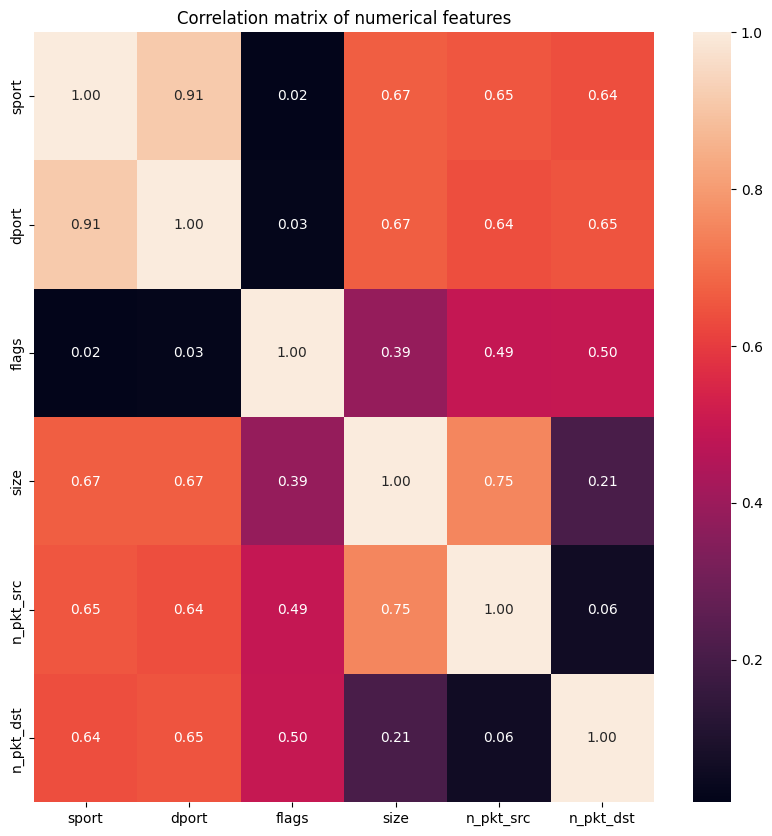

In [23]:
# Plot correlation matrix with sns
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.title("Correlation matrix of numerical features")
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


The analysis reveals the following relationships between the different variables:

1. **`sport` and `dport`**:
   - These two variables continue to show a strong positive correlation (\(0.913909\)), indicating that the values of `sport` and `dport` tend to increase or decrease together.

2. **`sport`, `dport`, and `size`**:
   - `sport` and `size` exhibit a moderate positive correlation (\(0.667260\)).
   - `dport` and `size` also show a moderate positive correlation (\(0.667895\)).
   - These correlations suggest that increases in the values of `sport` and `dport` are generally associated with increases in the packet size (`size`).

3. **`size` and `n_pkt_src`**:
   - These two variables have a relatively strong positive correlation (\(0.752641\)), indicating that increases in packet size are often associated with increases in the number of packets originating from the source.

4. **`flags`**:
   - `flags` shows moderate positive correlations with `n_pkt_src` (\(0.493689\)) and `n_pkt_dst` (\(0.495567\)), and a weaker correlation with `size` (\(0.385702\)).
   - This suggests that increases in the values of `flags` are generally associated with increases in the number of packets originating from the source, the number of packets destined, and the packet size.

5. **`n_pkt_src` and `n_pkt_dst`**:
   - These two variables show a very weak positive correlation (\(0.062721\)), indicating that the number of packets originating from the source and the number of packets destined are not strongly linked.

6. **`sport`, `dport`, `n_pkt_src`, and `n_pkt_dst`**:
   - These variables show moderate positive correlations among themselves, suggesting some relationship in their movements.

In summary, the strongest relationships are observed between `sport` and `dport`, as well as between `size` and `n_pkt_src`. The other correlations are more moderate or weak, indicating less direct relationships between these variables.

Now let's take a look at the correlation between the categorical features:

In [24]:
# Apply label encoding to all object columns
# If we use one-hot encoding, we will have a correlation matrix with almost 1000+ columns and lines
from sklearn.preprocessing import LabelEncoder

cpy_df_network = df_network.copy()
label_encoder = LabelEncoder()
for col in object_cols:
    cpy_df_network[col] = label_encoder.fit_transform(df_network[col])
cpy_df_network[object_cols].head()

cpy_df_network = remove_nan_through_mean_imputation(cpy_df_network)

In [25]:
corr_matrix = cpy_df_network[object_cols].corr(method="spearman").abs()
corr_matrix

,mac_s,mac_d,ip_s,ip_d,proto,modbus_fn
mac_s,1.000000,0.331400,0.193150,0.148599,0.578621,0.295003
mac_d,0.331400,1.000000,0.149861,0.170083,0.516733,0.353727
ip_s,0.193150,0.149861,1.000000,0.834745,0.059539,0.369480
ip_d,0.148599,0.170083,0.834745,1.000000,0.052825,0.263606
proto,0.578621,0.516733,0.059539,0.052825,1.000000,0.463579
modbus_fn,0.295003,0.353727,0.369480,0.263606,0.463579,1.000000


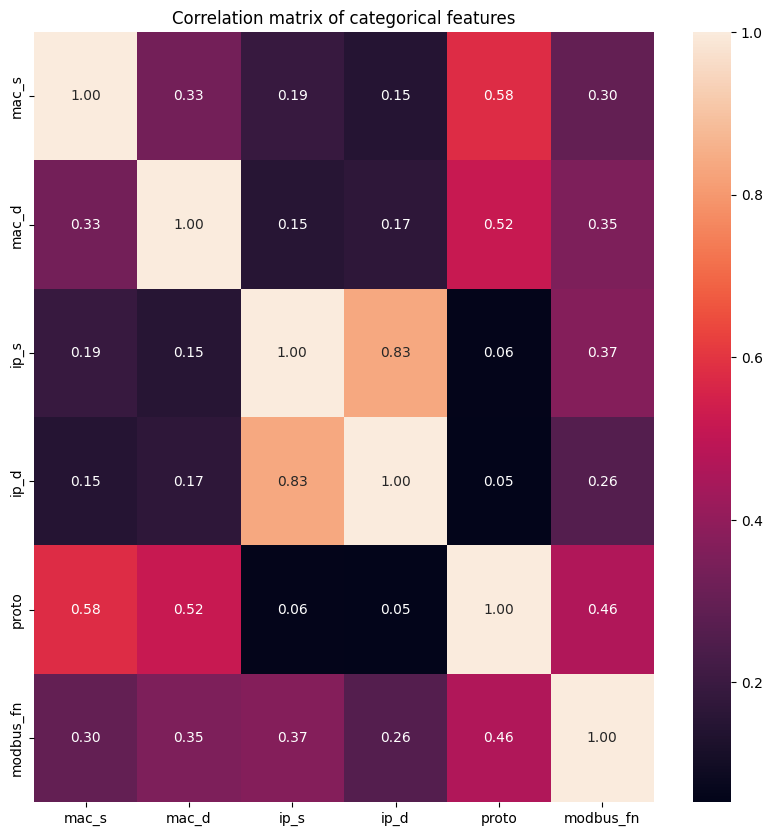

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.title("Correlation matrix of categorical features")
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

The analysis of the provided correlation matrix reveals the following insights:

1. **`ip_s` and `ip_d`**:
   - These variables show a strong positive correlation (\(0.834745\)), suggesting that the source and destination IP addresses are often related.

2. **`proto`**:
   - `proto` exhibits moderate positive correlations with `mac_s` (\(0.578621\)) and `mac_d` (\(0.516733\)), and a slightly lower correlation with `modbus_fn` (\(0.463579\)).
   - This indicates that changes in the `proto` value are somewhat associated with changes in the source and destination MAC addresses, as well as the Modbus function code.

3. **`modbus_fn`**:
   - `modbus_fn` shows moderate positive correlations with `ip_s` (\(0.369480\)) and `mac_d` (\(0.353727\)), suggesting that the Modbus function code tends to change with variations in these values.

4. **`mac_s` and `mac_d`**:
   - These variables have a moderate positive correlation (\(0.331400\)), indicating that there is some relationship between the source and destination MAC addresses.

5. **Other Correlations**:
   - The other pairs of variables show weak correlations, suggesting that there are no strong linear relationships between them.

Overall, the most significant relationship is observed between `ip_s` and `ip_d`, while other variables have moderate or weak correlations.

Finally let's look at the correlation between all the features:

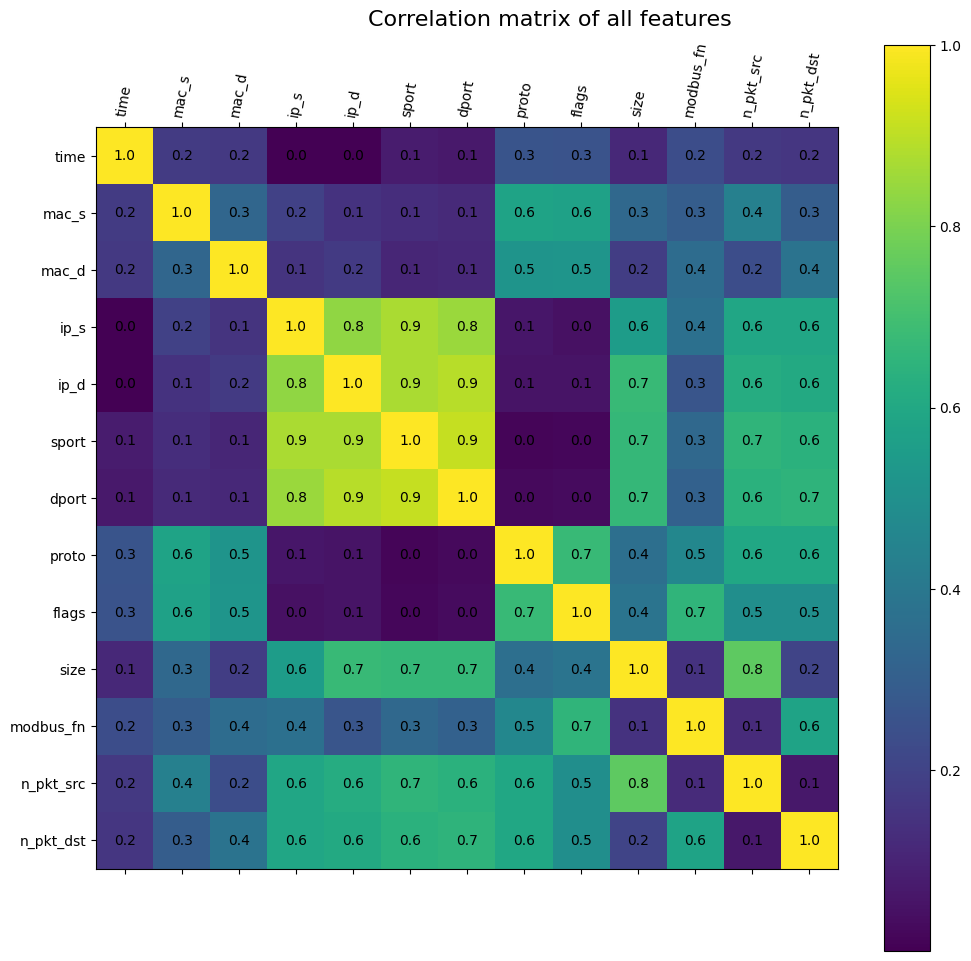

In [27]:
corr_matrix = cpy_df_network.corr(
    method="spearman"
).abs()  # All the features columns are already enocded

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Correlation matrix of all features", fontsize=16)
fig.tight_layout()
im = ax.matshow(corr_matrix)
fig.colorbar(im)
ticks = np.arange(0, len(corr_matrix.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(cpy_df_network.columns.tolist(), rotation=80)
ax.set_yticklabels(cpy_df_network.columns.tolist())

for (i, j), z in np.ndenumerate(corr_matrix):
    ax.text(j, i, "{:0.1f}".format(z), ha="center", va="center")
plt.show()

The whole correlation matrix is very hard to read, so we'll focus on the most interesting parts.
We can see the same anaylysis as before, from the two separated kinds of features but we can also see that the algorithm is struggling to find any correlation between the two types of features. This is surely due to how we encoded our categorical features.

### Let's try to go a bit deeper and plot the labels as a time series

In [28]:
df_network[network_dataset_labels.columns] = network_dataset_labels

df_network_sorted = df_network.sort_values(by=["time"])
df_network_sorted["time_minute"] = pd.to_datetime(
    df_network_sorted["time"], unit="s"
).dt.strftime("%m-%d %H:%M")
df_network_sorted.head()

,time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,label_n,label,attack,time_minute
165493,1.617968e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,61516.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,49.0,0,normal,0,04-09 11:30
165494,1.617968e+09,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,61517.0,502.0,Modbus,11000.0,66,Read Coils Request,49.0,15.0,0,normal,0,04-09 11:30
165495,1.617968e+09,fa:00:bc:90:d7:fa,74:46:a0:bd:a7:1b,84.3.251.103,84.3.251.20,502.0,61516.0,Modbus,11000.0,65,Read Holding Registers Response,18.0,43.0,0,normal,0,04-09 11:30
165496,1.617968e+09,0a:fe:ec:47:74:fb,74:46:a0:bd:a7:1b,84.3.251.102,84.3.251.20,502.0,61517.0,Modbus,11000.0,65,Read Holding Registers Response,18.0,44.0,0,normal,0,04-09 11:30
165497,1.617968e+09,e6:3f:ac:c9:a8:8c,74:46:a0:bd:a7:1b,84.3.251.101,84.3.251.20,502.0,61515.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,0,normal,0,04-09 11:30


In [29]:
df_grouped = (
    df_network_sorted.groupby(["time_minute", "label_n"]).size().unstack().fillna(0)
)
df_grouped

label_n,0,1
time_minute,,
04-09 11:30,164.0,0.0
04-09 11:31,1365.0,0.0
04-09 11:32,1362.0,0.0
04-09 11:33,1360.0,0.0
04-09 11:34,1360.0,0.0
...,...,...
04-19 16:08,593.0,772.0
04-19 16:09,0.0,1368.0
04-19 16:10,1334.0,30.0


<Axes: xlabel='time_minute'>

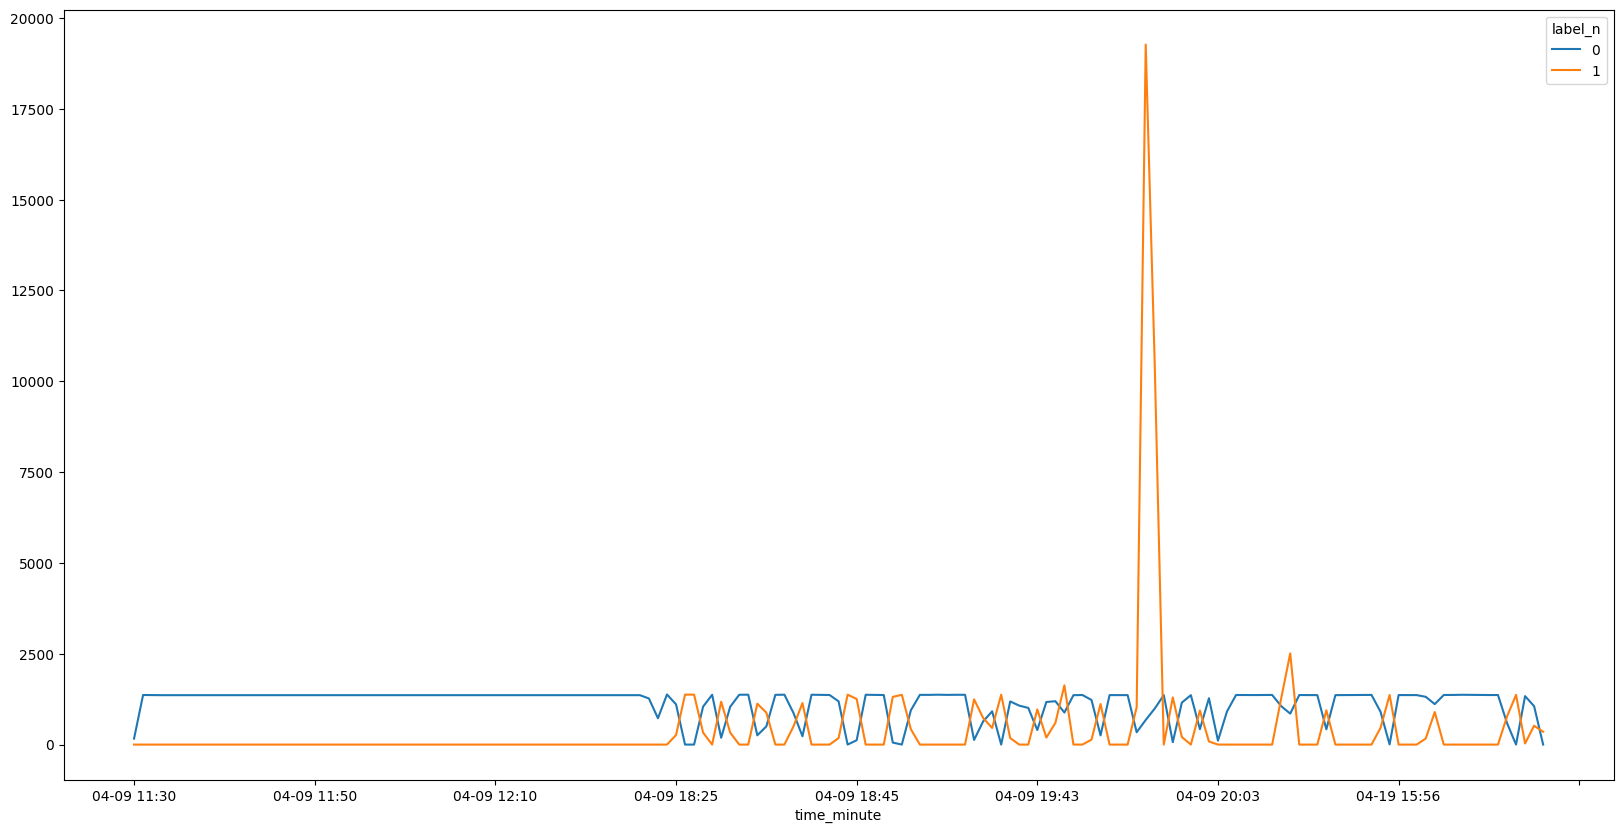

In [30]:
df_grouped.loc[:].plot(figsize=(20, 10))

Firstly, let's see the number of anormal data per minute for the "normal" dataset

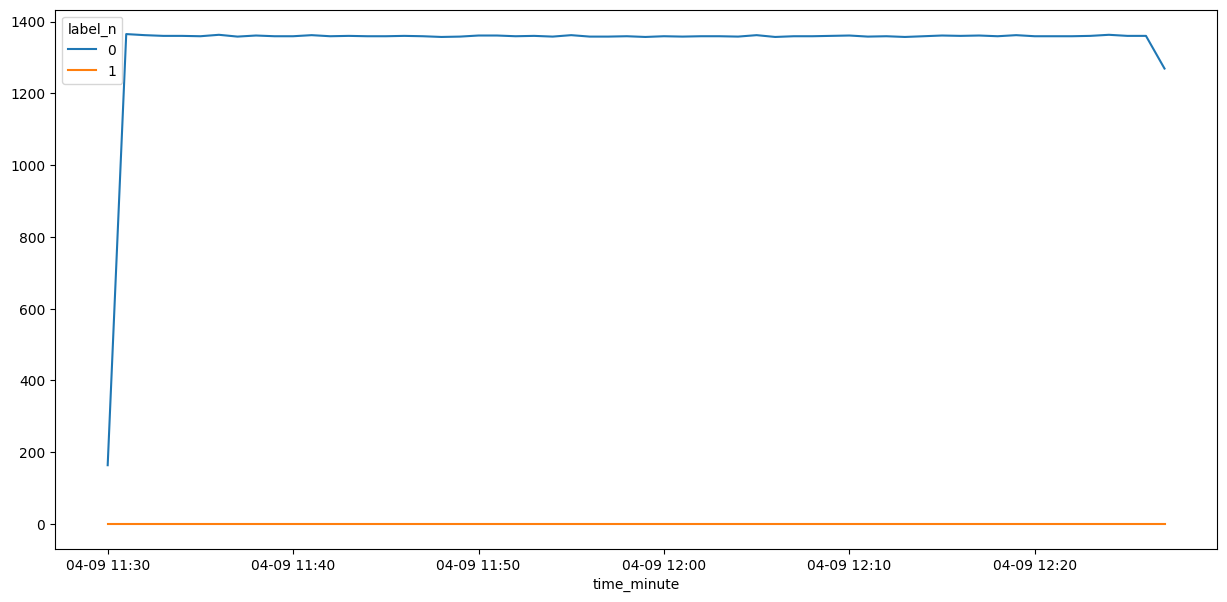

In [31]:
df_grouped.loc["04-09 11":"04-09 13"].plot(figsize=(15, 7))
plt.show()

As expected, there is no 1 label in the normal dataset. Let's check for 2020-04-09 (first day of recorded anomalies)

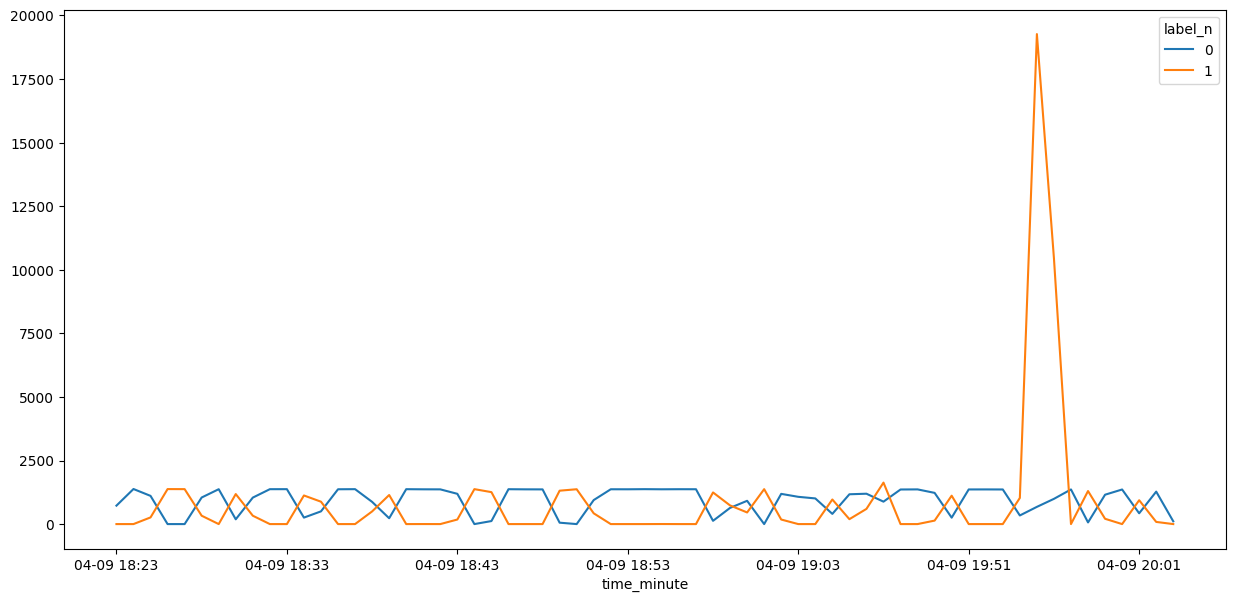

In [32]:
df_grouped.loc["04-09 18":"04-09 22"].plot(figsize=(15, 7))
plt.show()

We see way more fluctuation in the data. There is anormal activity for some time, then it stops, then it starts again with a huge peak

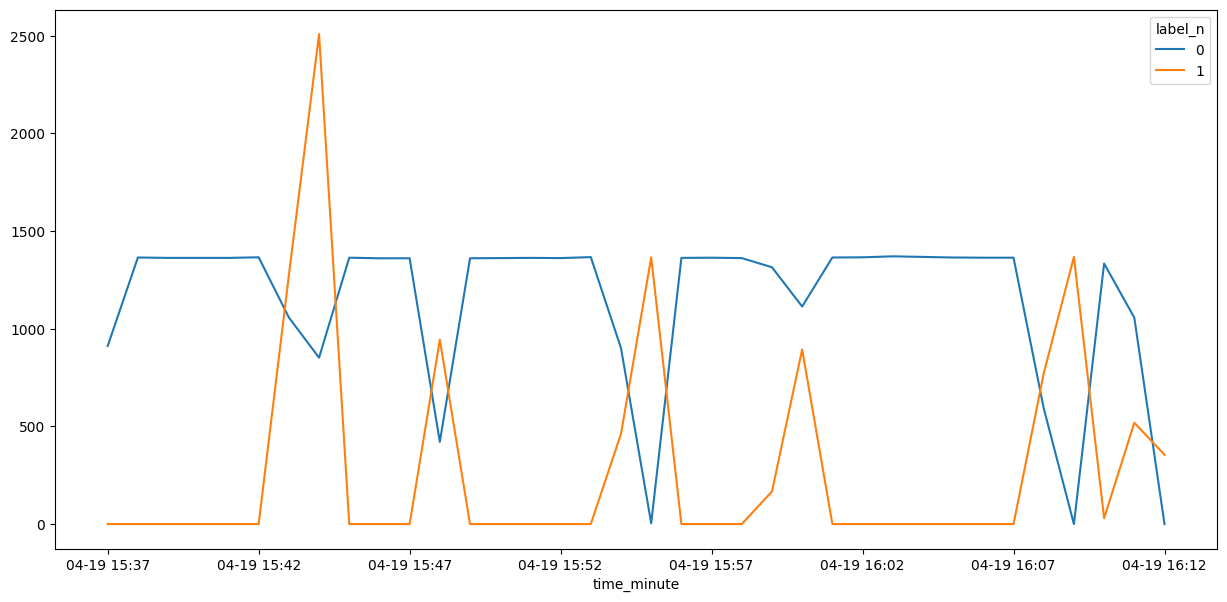

In [33]:
df_grouped.loc["04-19":"04-20"].plot(figsize=(15, 7))
plt.show()

## Physical dataset exploration

In [34]:
df_physical.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,attack
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.0,normal,1


In [35]:
df_physical.columns

Index(['time', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6',
       'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5',
       'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3',
       'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5',
       'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12',
       'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18',
       'valv_19', 'valv_20', 'valv_21', 'valv_22', 'label_n', 'label',
       'attack'],
      dtype='object')

Dtypes of the columns:

In [36]:
df_physical.dtypes

time             float64
tank_1             int64
tank_2             int64
tank_3             int64
tank_4             int64
tank_5             int64
tank_6             int64
tank_7             int64
tank_8             int64
pump_1             int64
pump_2             int64
pump_3             int64
pump_4             int64
pump_5             int64
pump_6             int64
flow_sensor_1      int64
flow_sensor_2      int64
flow_sensor_3      int64
flow_sensor_4      int64
valv_1             int64
valv_2             int64
valv_3             int64
valv_4             int64
valv_5             int64
valv_6             int64
valv_7             int64
valv_8             int64
valv_9             int64
valv_10            int64
valv_11            int64
valv_12            int64
valv_13            int64
valv_14            int64
valv_15            int64
valv_16            int64
valv_17            int64
valv_18            int64
valv_19            int64
valv_20            int64
valv_21            int64


Let's look at the proportion of nan values per column:

In [37]:
df_physical.isna().sum() / df_physical.shape[0] * 100

time             0.0
tank_1           0.0
tank_2           0.0
tank_3           0.0
tank_4           0.0
tank_5           0.0
tank_6           0.0
tank_7           0.0
tank_8           0.0
pump_1           0.0
pump_2           0.0
pump_3           0.0
pump_4           0.0
pump_5           0.0
pump_6           0.0
flow_sensor_1    0.0
flow_sensor_2    0.0
flow_sensor_3    0.0
flow_sensor_4    0.0
valv_1           0.0
valv_2           0.0
valv_3           0.0
valv_4           0.0
valv_5           0.0
valv_6           0.0
valv_7           0.0
valv_8           0.0
valv_9           0.0
valv_10          0.0
valv_11          0.0
valv_12          0.0
valv_13          0.0
valv_14          0.0
valv_15          0.0
valv_16          0.0
valv_17          0.0
valv_18          0.0
valv_19          0.0
valv_20          0.0
valv_21          0.0
valv_22          0.0
label_n          0.0
label            0.0
attack           0.0
dtype: float64

Surprinsigly, coming from a dataset that has been made from physical data capture, this dataset has no NaN values. 

### Labels

Let's take a quick detour to see what are the labels like.

In [38]:
physical_dataset_labels = df_physical[["label_n", "label"]]
df_physical = df_physical.drop(columns=["label_n", "label"])

In [39]:
physical_dataset_labels.head(3)

,label_n,label
0,0.0,normal
1,0.0,normal
2,0.0,normal


In [40]:
physical_dataset_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

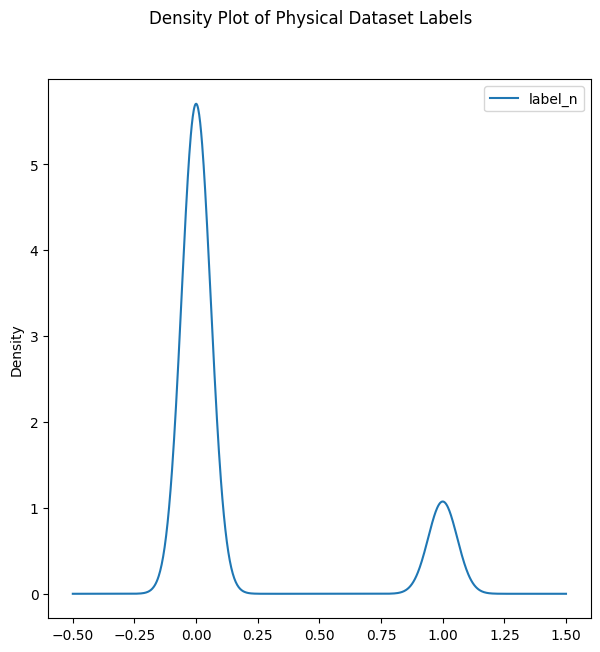

In [41]:
physical_dataset_labels.plot(
    kind="density",
    subplots=True,
    layout=(1, 1),
    sharex=False,
    figsize=(7, 7),
    title="Density Plot of Physical Dataset Labels",
)
plt.show()

Our dataset is unbalanced, the ratio seems to be 1/4.

In [42]:
physical_dataset_labels["label"].value_counts()

label
normal            7747
MITM               743
physical fault     552
DoS                157
scan                 7
Name: count, dtype: int64

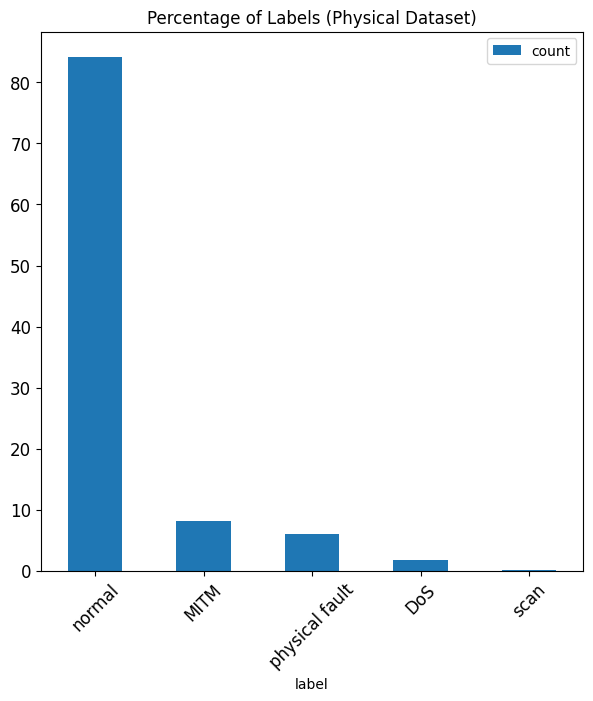

In [43]:
# Get dataset labels value counts
physical_dataset_labels_value_counts = physical_dataset_labels["label"].value_counts()

# Ratio of each label
physical_dataset_labels_value_counts = (
    physical_dataset_labels_value_counts
    / physical_dataset_labels_value_counts.sum()
    * 100
)

# Bar plot of the dataset labels
physical_dataset_labels_value_counts.plot(
    kind="bar",
    title="Percentage of Labels (Physical Dataset)",
    figsize=(7, 7),
    rot=45,
    legend=True,
    fontsize=12,
)
plt.show()

We have 5 labels: normal, DoS, MITM, physical fault, anomaly.
More imporantly the data is also split is normal (label_n=0) or not normal (label_n=1).

This is the same as our network dataset.

However, the most noticeable thing is that the physical dataset has less than a hundred samples.

### Features

In [44]:
assert np.all([t in [int, float] for t in df_physical.dtypes])
len(df_physical.columns)  # 42
df_physical.columns

Index(['time', 'tank_1', 'tank_2', 'tank_3', 'tank_4', 'tank_5', 'tank_6',
       'tank_7', 'tank_8', 'pump_1', 'pump_2', 'pump_3', 'pump_4', 'pump_5',
       'pump_6', 'flow_sensor_1', 'flow_sensor_2', 'flow_sensor_3',
       'flow_sensor_4', 'valv_1', 'valv_2', 'valv_3', 'valv_4', 'valv_5',
       'valv_6', 'valv_7', 'valv_8', 'valv_9', 'valv_10', 'valv_11', 'valv_12',
       'valv_13', 'valv_14', 'valv_15', 'valv_16', 'valv_17', 'valv_18',
       'valv_19', 'valv_20', 'valv_21', 'valv_22', 'attack'],
      dtype='object')

All of our features are numbers.

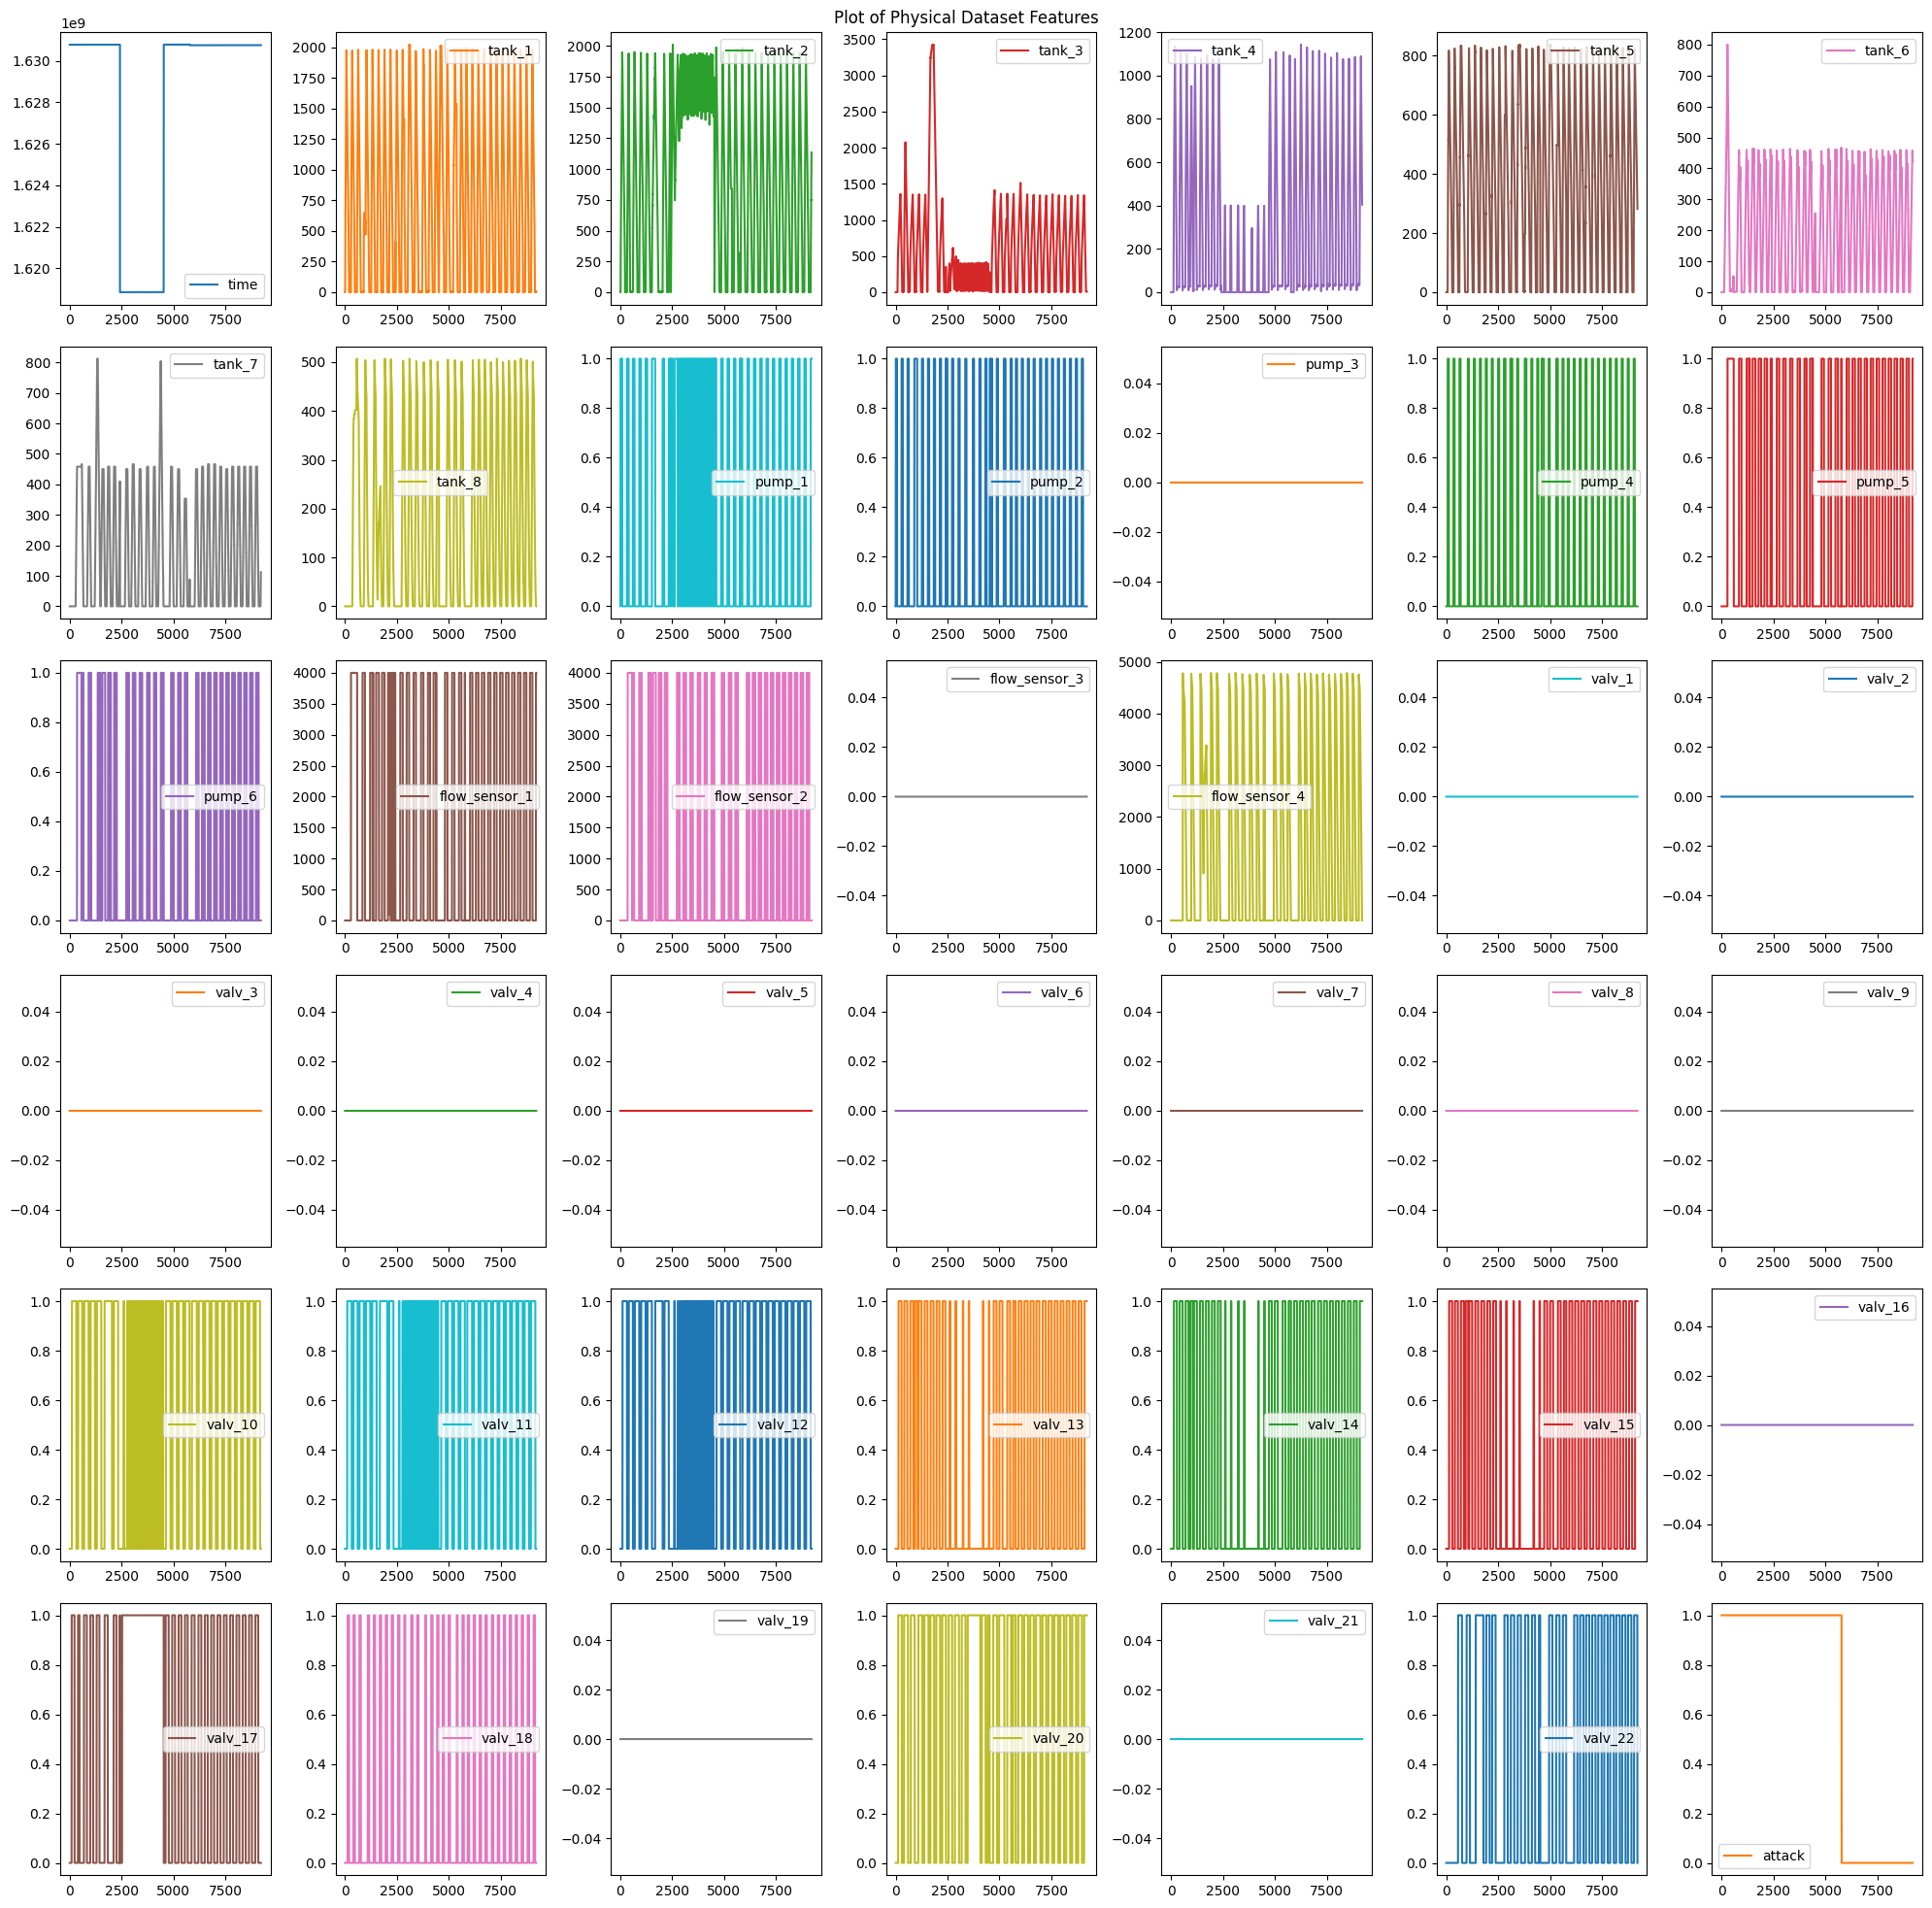

In [45]:
df_physical.plot(
    subplots=True,
    layout=(6, 7),
    sharex=False,
    figsize=(20, 20),
    title="Plot of Physical Dataset Features",
)
plt.tight_layout()
plt.show()

We can see that some features are constrant troughout the dataset, let's remove them and look at the density of the rest of the features.

In [46]:
n_removed_cols = 0
for col in df_physical.columns:
    unique_values = df_physical.loc[:, col].value_counts()
    if len(unique_values) == 1:
        df_physical.drop(columns=col, inplace=True)
        n_removed_cols += 1
print("Number of columns removed: ", n_removed_cols)

Number of columns removed:  14


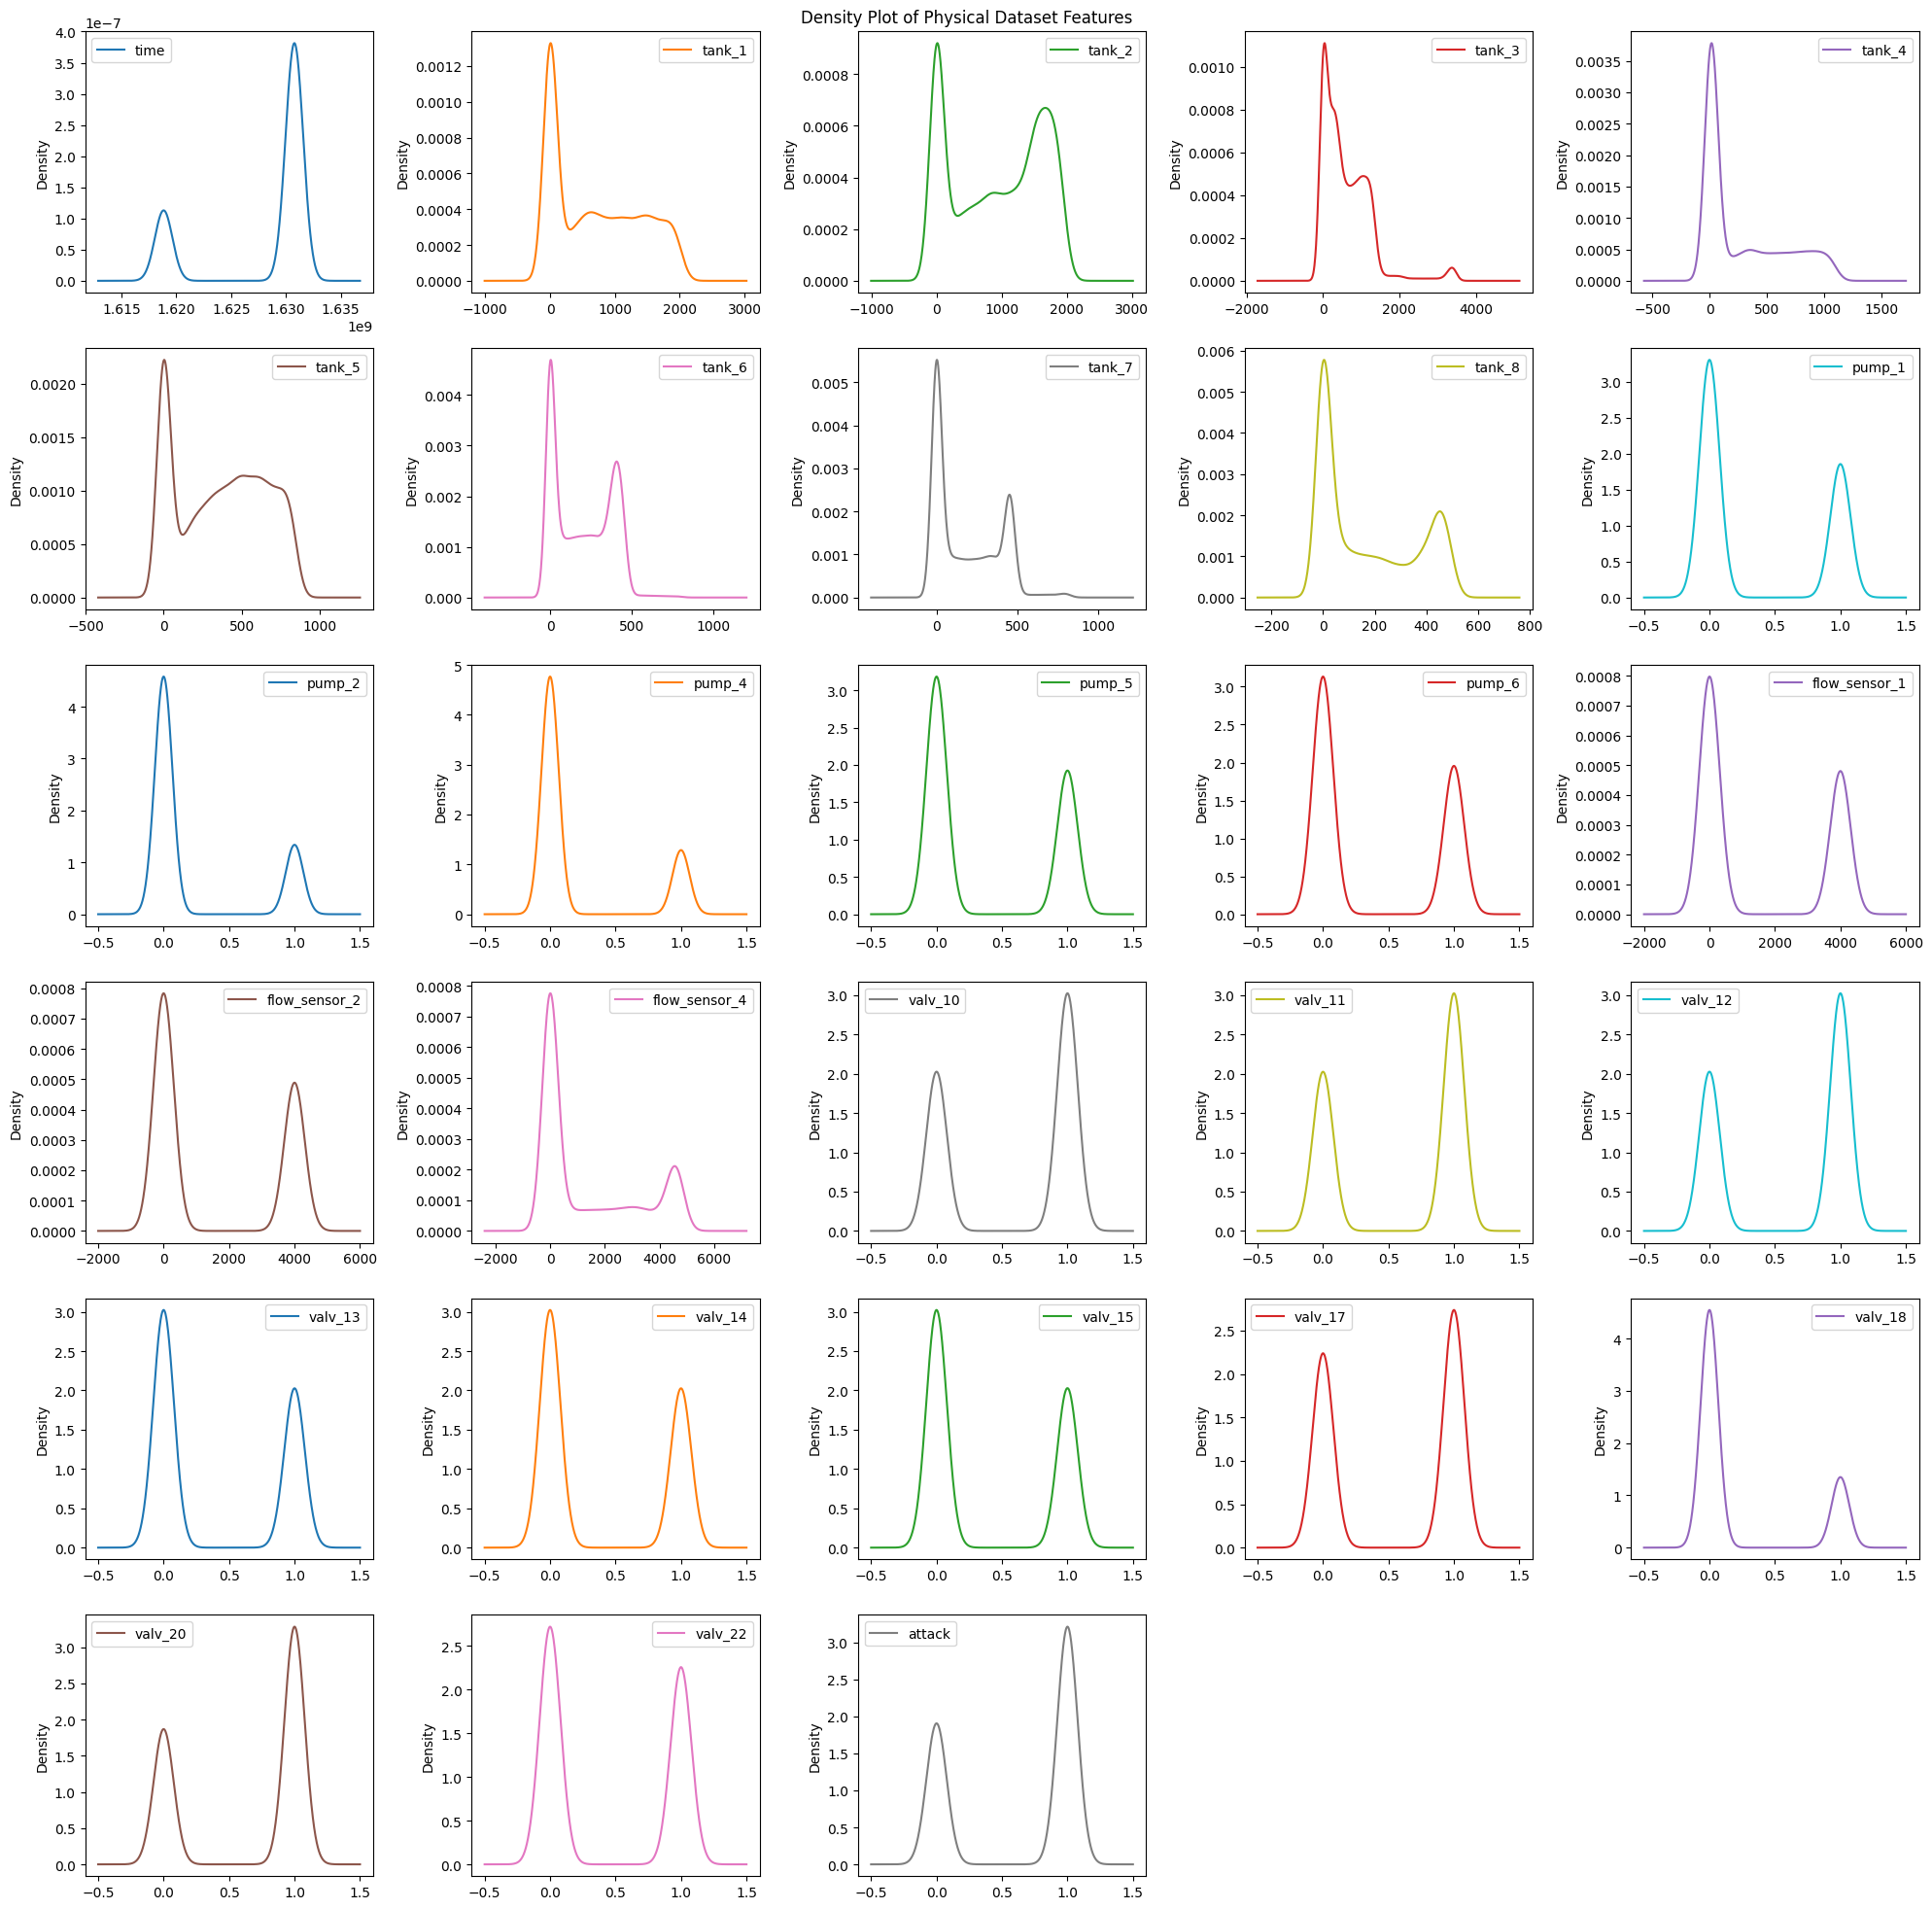

In [47]:
# Let's plot the density to have a better look at the data repartition
df_physical.plot(
    kind="density",
    subplots=True,
    layout=(6, 5),
    sharex=False,
    figsize=(20, 20),
    title="Density Plot of Physical Dataset Features",
)
plt.tight_layout()
plt.show()

Let's quickly analyse the density of the numerical columns:
- `tank`: most of the data is around 0. The sensors 2, 5 and 6 have non-zero values that are proportionnaly bigger or on par with the 0 values.
- `pump`: boolean, 0 or 1. 0 is 2x/3x more dense than 1.
- `flow_sensor`: int, between 0 and 6000. Most of the data is 0, all sensors have a spike around 4000.
- `valv`: boolean, 0 or 1. The distribution between the two values differ a lot between the sensors.


Now, let's look at the correlation between the features:

In [48]:
# Correlation matrix
corr_matrix = df_physical.corr(method="spearman").abs()

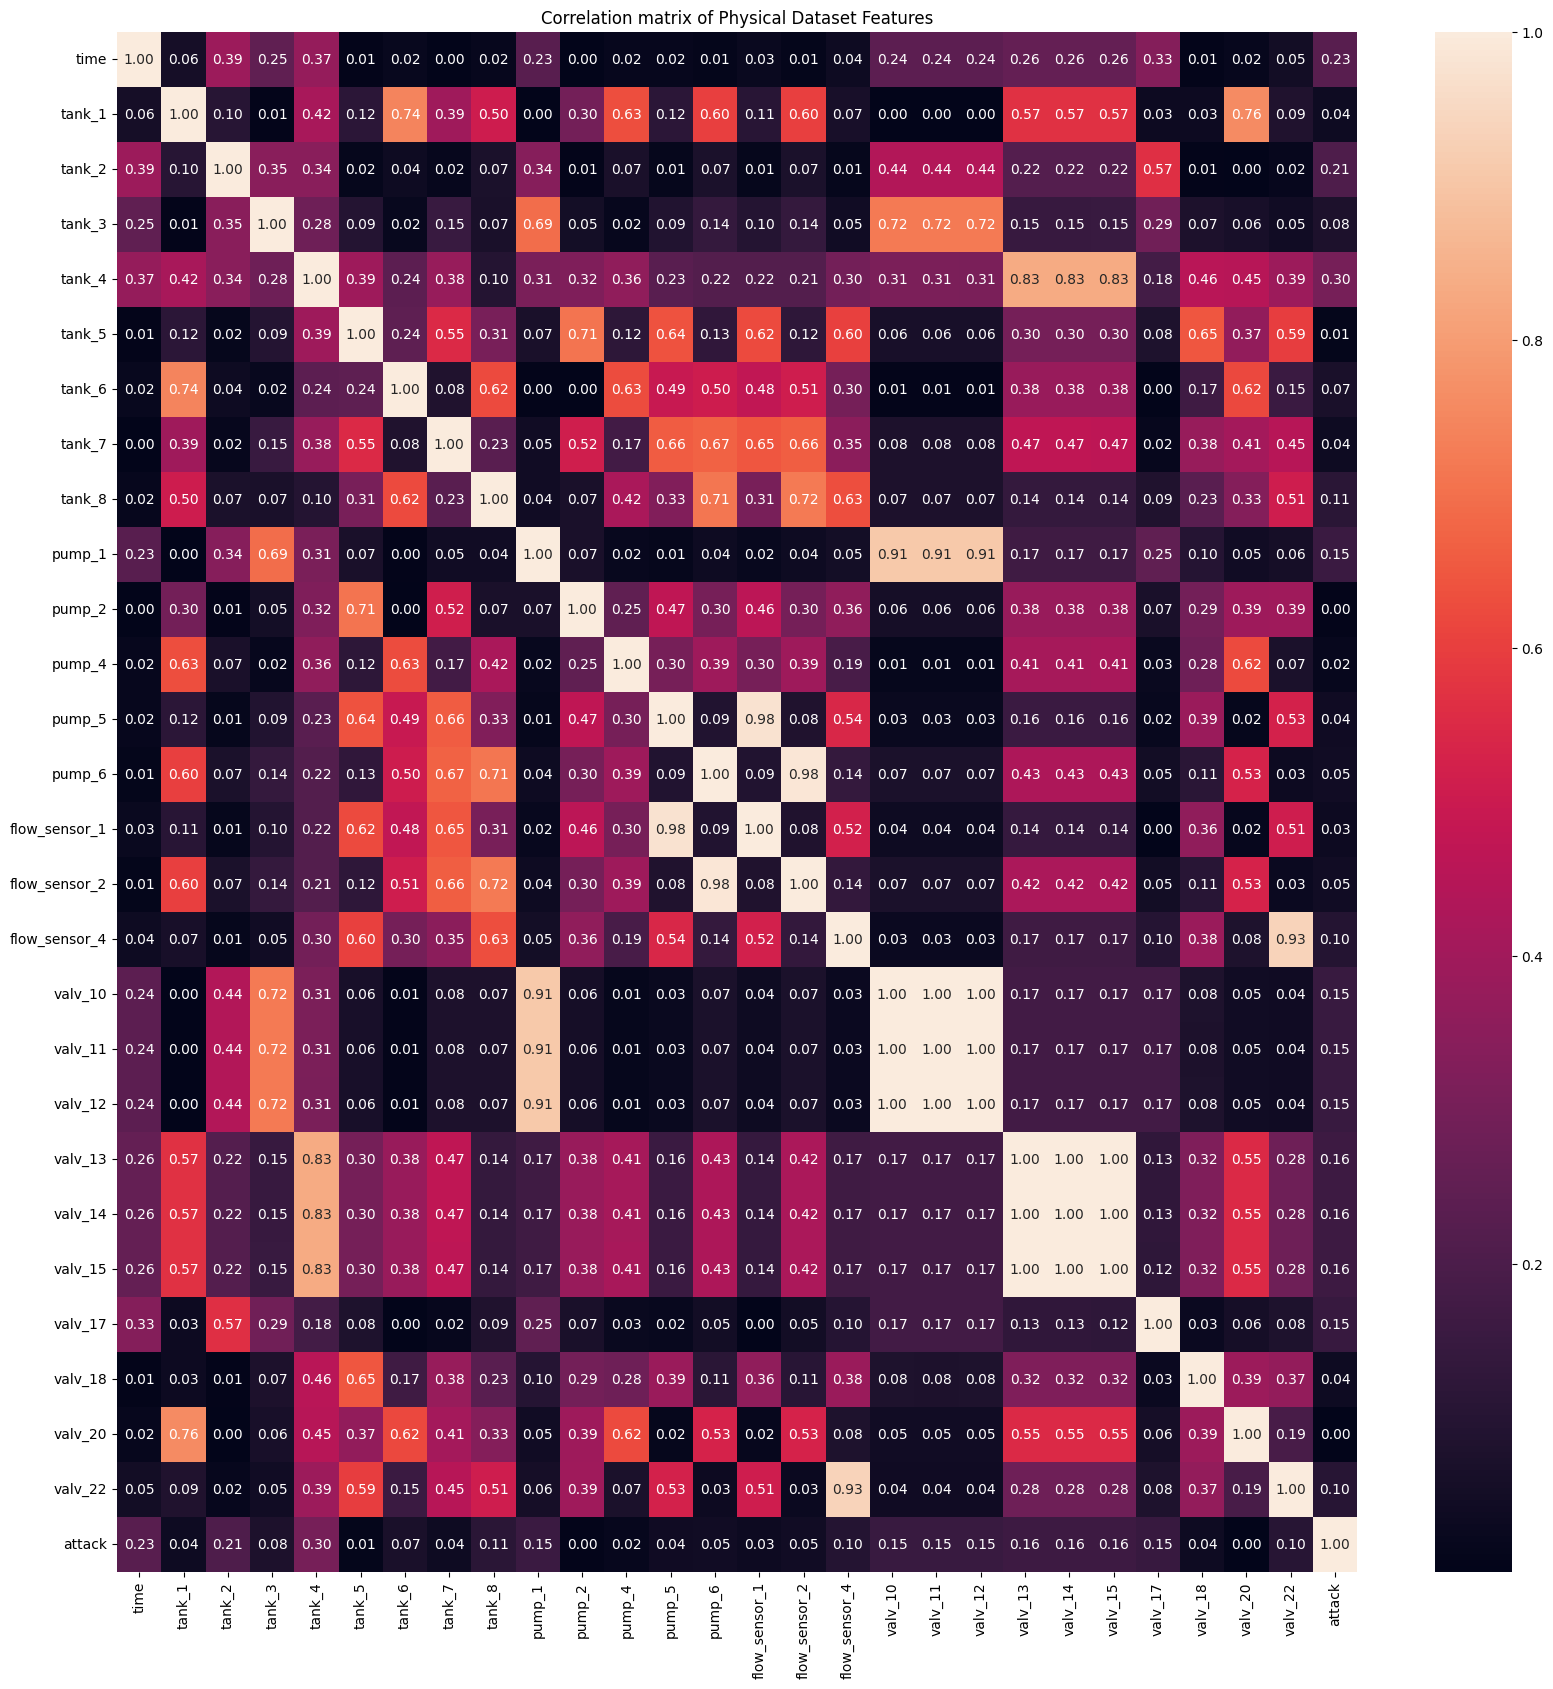

In [49]:
# Plot correlation matrix with sns
plt.figure(figsize=(20, 20))
plt.title("Correlation matrix of Physical Dataset Features")
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

As we can see the matrix is way to big to be read easily.
There doesn´t seem to be any correlation between the four sensors.

As expected, we can see that some groups of the same sensors are correlated together.

### Side note: Time series

The data is recorded at two points in time. Let's cluster them to see what we can find.

In [50]:
# Cluster the time column
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

time_col = df_physical["time"].values.reshape(-1, 1)
scaler = StandardScaler()
time_col_scaled = scaler.fit_transform(time_col)

kmeans = KMeans(n_clusters=2, random_state=random_state)

kmeans.fit(time_col_scaled)

df_physical["time_cluster"] = kmeans.labels_

/home/arnaudb/Documents/EPITA/ING3/ml-secu/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Here we can see that we have two clusters. Is is the same for the network dataset. We can see that in the density plot of the number values of the network dataset.

Back to our physical dataset, let's look at the time series of the sensors.

Let's try to scatter plot the data of each sensor category combined relative to the timestep of each cluster.

In [71]:
def print_scatter_chart(df, sensor_list, logx=False, logy=False):
    subplot_size = int(np.sqrt(len(sensor_list)))
    fig, axs = plt.subplots(subplot_size, subplot_size, figsize=(20, 20))
    fig.suptitle("Scatter chart of each sensor type", fontsize=20)

    # For each sensor type, plot the scatter chart
    for sensor_prefix in sensor_list:
        columns = df.columns[df.columns.str.startswith(sensor_prefix)]

        # Create a scatter chart with each column in columns with a different color
        ax = axs.flatten()[sensor_list.index(sensor_prefix)]
        is_bool = True
        for i, col in enumerate(columns):
            if len(np.unique(df[col])) > 2:
                is_bool = False
                break

        for i, col in enumerate(columns):
            df.plot(
                kind="scatter",
                x="time_readable",
                y=col,
                color=f"C{i}",
                ax=ax,
                label=col,
                logx=logx,
                logy=logy if not is_bool else False,
            )

        # Plot it
        ax.tick_params(axis="x", labelrotation=45)  # Better readability
        ax.set_title(sensor_prefix[:-1])
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.set_xticks(ax.get_xticks()[::100])

        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()

In [72]:
first_cluster = df_physical[df_physical["time_cluster"] == 0]

# Compute the max span of time col in readable format
max_span = first_cluster.loc[:, "time"].max() - first_cluster.loc[:, "time"].min()
max_span_readable = pd.to_datetime(max_span, unit="s").strftime("%H:%M:%S")
print("Max span of time col in First cluster: ", max_span_readable)

# Get the time in MM:SS format
x_axis_time = pd.to_datetime(first_cluster.loc[:, "time"], unit="s").dt.strftime(
    "%H:%M:%S"
)

Max span of time col in First cluster:  00:35:04


/tmp/ipykernel_1060010/3516031925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cluster.loc[:, "time_readable"] = x_axis_time


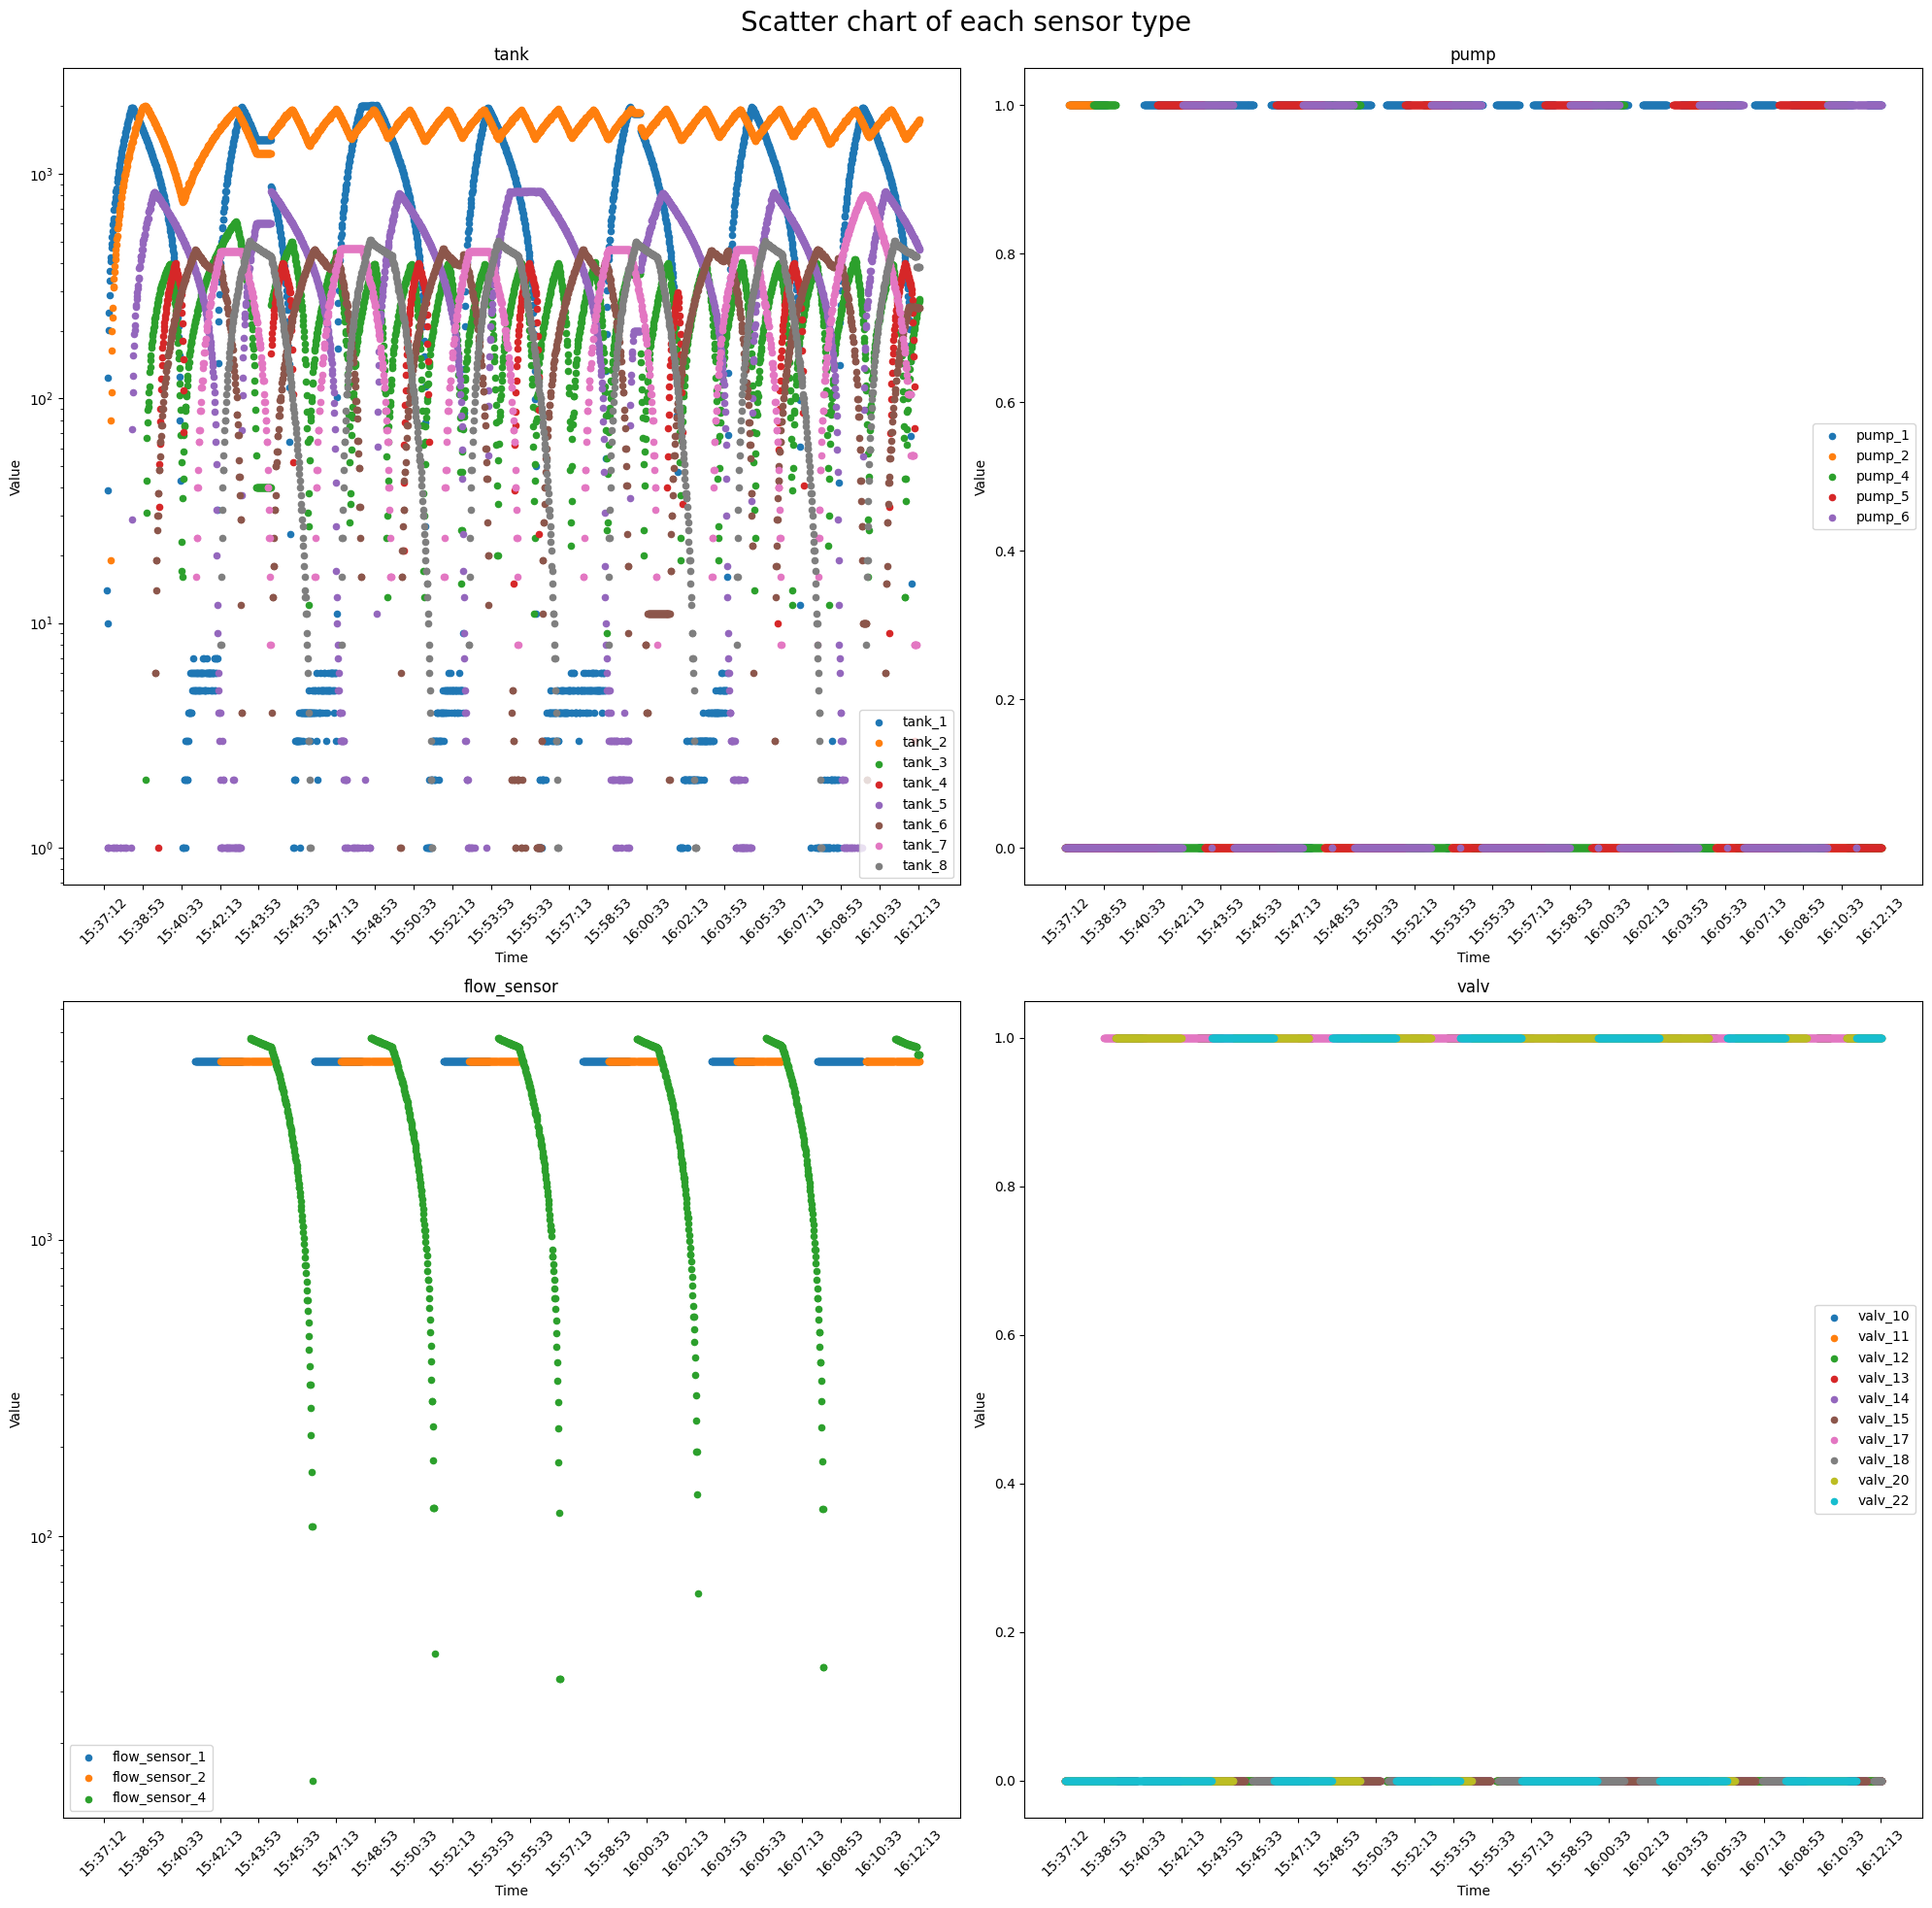

In [73]:
# Plot a scatter chart for every type of sensor in the first cluster
sensor_list = ["tank_", "pump_", "flow_sensor_", "valv_"]
first_cluster.loc[:, "time_readable"] = x_axis_time
print_scatter_chart(first_cluster, sensor_list, logy=True)

- There seem to be a pattern in the values for `tank_2` ,`tank_3`, `tank_5` and `tank_7`. Very few values are low.
- `pump` has 7 occurences where none of them are True.
- `flow_sens_4` seems to be the one that varies the most.
- `valv`s have only one occurence where none of them are False. This is surely due to the amount of sensors we had in this category

Second Cluster

In [74]:
second_cluster = df_physical[df_physical["time_cluster"] == 0]

# Compute the max span of time col in readable format
max_span = second_cluster["time"].max() - second_cluster["time"].min()
max_span_readable = pd.to_datetime(max_span, unit="s").strftime("%H:%M:%S")
print("Max span of time col in First cluster: ", max_span_readable)

# Get the time in MM:SS format
x_axis_time = pd.to_datetime(second_cluster.loc[:, "time"], unit="s").dt.strftime(
    "%H:%M:%S"
)

Max span of time col in First cluster:  00:35:04


/tmp/ipykernel_1060010/4065412669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_cluster.loc[:, "time_readable"] = x_axis_time


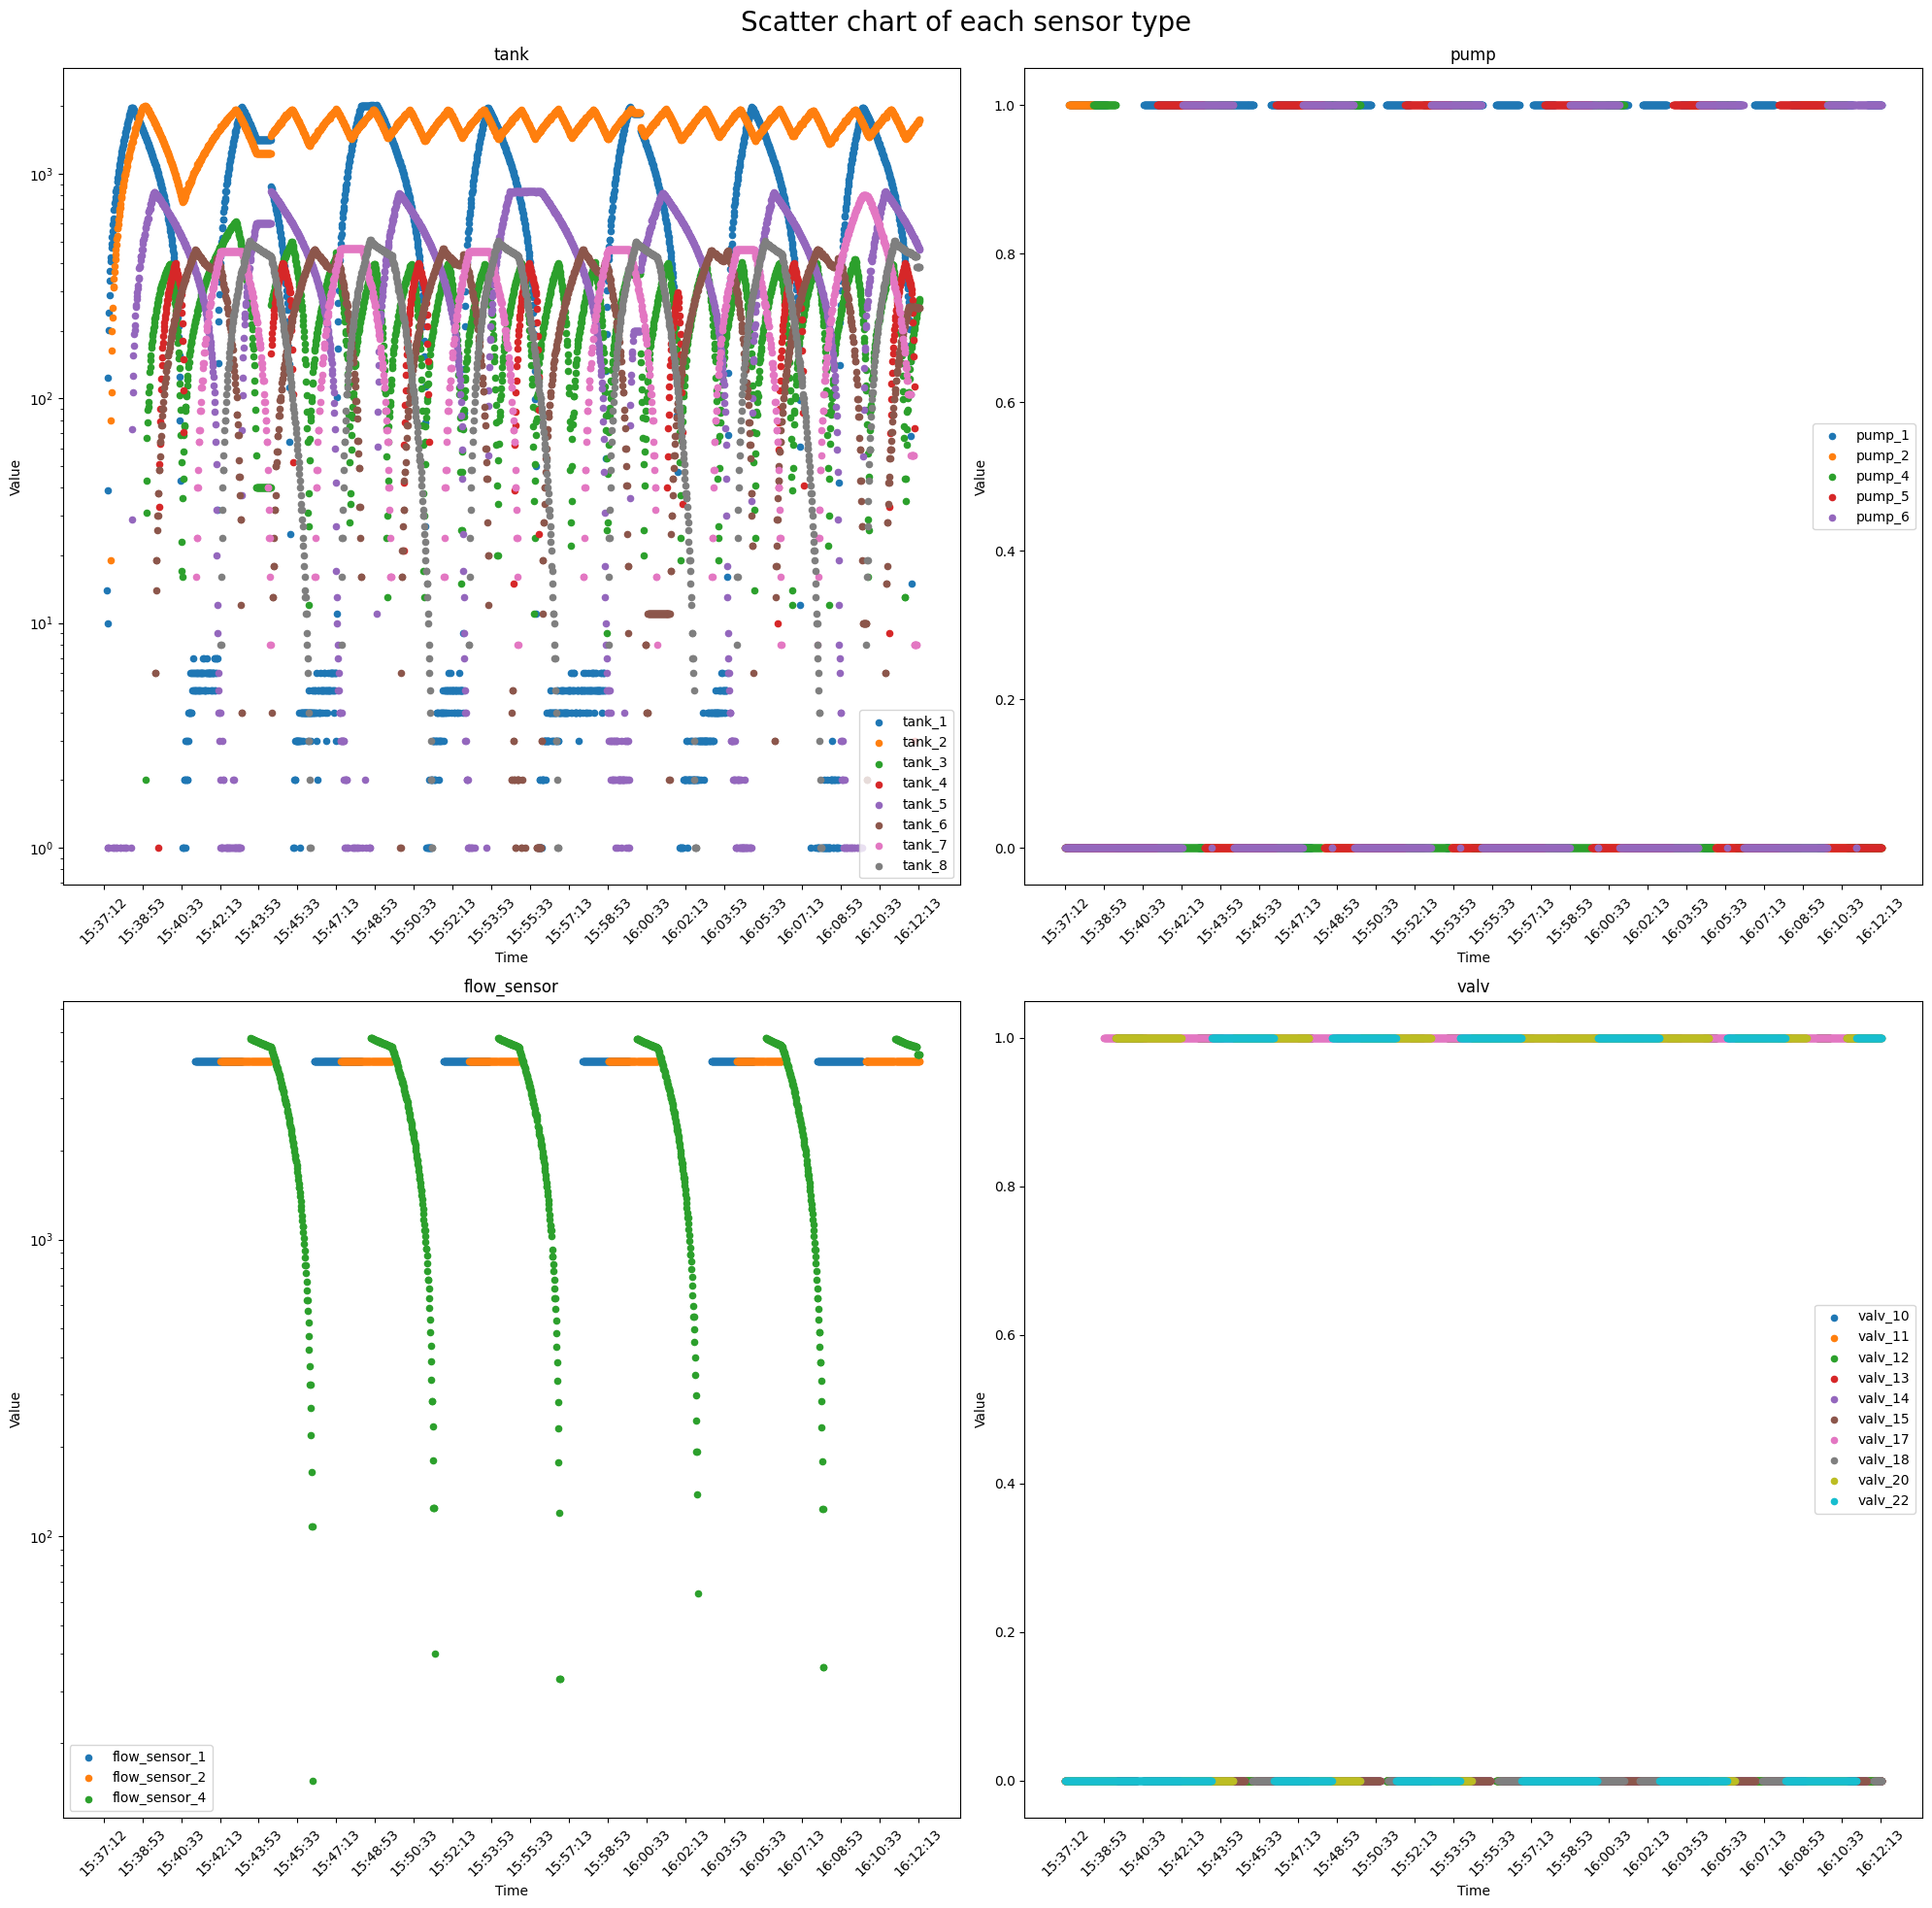

In [75]:
# Plot a scatter chart for every type of sensor
sensor_list = ["tank_", "pump_", "flow_sensor_", "valv_"]
second_cluster.loc[:, "time_readable"] = x_axis_time
print_scatter_chart(second_cluster, sensor_list, logy=True)

The behavior of the second cluster is very similar to the first one.

## Conclusion

The dataset, originating from the Water Distribution Testbed, encompasses both physical and network data, essential for understanding the impact of attacks on the physical process and network traffic. In the network dataset analysis, we examined feature distributions, laying the foundation for feature engineering and model building.

Subsequently, in the physical dataset, we were pleasantly surprised to find no missing values, albeit with label imbalance issues. Our features underwent density analysis, highlighting patterns in the different system points of capture: tanks, pumps, flow sensors, and valves.

In addition, we delved into the dataset's time series aspects, clustering the data for in-depth examination.

Overall, these analyses provide crucial insights for our ongoing project, aiding in feature selection, preprocessing, and subsequent modeling.